In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline
from scipy.stats import norm
from scipy.optimize import minimize, curve_fit
import uproot
import tqdm
import time
from IPython.display import display
import seaborn as sns
colors = sns.color_palette('colorblind')

# optional: use LaTex style for matplotlib
mpl.style.use("/Users/svan/Software/paper.mplstyle")
# mpl.style.use("/Users/pinguino/paper.mplstyle")

# pGRAMS Readout Analysis Notebook

Plotting and analysis tools for the pGRAMS readout chain. After loading in decoded ADC data (currently via sshfs remote mount), the following plots and outputs can be produced:

- **Waveform Plots** (input data: any run)
  - Plot waveform for a specific channel and a specific event
  - Plot waveforms of all channels for a specific event
  - Plot event-averaged waveform for a specific channel
- **ADC Calibration** (input data: single channel runs with injected pulses of varying height)
  - Plot ADC peak amplitude vs. input charge
  - Plot ADC peak ampl. vs. input charge with linear fit
  - Return resolution, dynamic range, saturation point
- **Noise Plots** (input data: baseline runs)
  - Baseline ADC counts histogram for a specific channel
  - Noise RMS for a given set of channels
- **Crosstalk** (input data: single channel runs with injected pulse)
  - Correlation for a specific active channel (correlation vs. channel number)
  - Correlation Matrix
 
Feel free to reach out to Svanik (st3624@columbia.edu) or Ibrahim (isafa@nevis.columbia.edu) with any questions!

## Import and Unpack Data

Currently, test data is located at **/home/ub/WinDriver/wizard/GRAMS_project_am** on the ub@sbndelec01.nevis.columbia.edu server. This notebook accesses this data by remote mounting the ub server's GRAMS directory onto your local machine. This requires sshfs to be installed on your machine:
- Ubuntu systems: run `sudo apt install sshfs` in terminal
- Mac: https://osxfuse.github.io/
- Windows: https://github.com/winfsp/sshfs-win

Once installed, run the following cell in order to make a mount point in your home directory named remote_mount.

In [2]:
GRAMSdir = os.path.expanduser("~/remote_mount")
os.makedirs(GRAMSdir, exist_ok=True) # make a mount point in your home directory if it doesn't already exist

If you set up passwordless ssh to ub, then you can use the cell below to mount the GRAMS directory. Otherwise, you can mount it manually by running the following command in your terminal:

```sshfs ub@sbndelec01.nevis.columbia.edu:/home/ub/WinDriver/wizard/GRAMS_project_am ~/remote_mount```

When you are done with the remote mount, you can unmount the directory via: `umount ~/remote_mount`

In [3]:
# # if you have passwordless ssh to ub set up, you can use this cell to remote mount the GRAMS directory on local machine
# host = "ub"
# remote_path = "/home/ub/WinDriver/wizard/GRAMS_project_am "

# # mount and unmount commands
# mount = f"sshfs {host}:{remote_path} {GRAMSdir} -o kill_on_unmount,reconnect,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa"
# unmount = f"umount {GRAMSdir}"

# try:
#     # make sure the directory is not currently mounted, then mount
#     subprocess.run(unmount, shell=True, check=True)
#     subprocess.run(mount, shell=True, check=True)
# except:
#     # otherwise just directly mount
#     subprocess.run(mount, shell=True, check=True)

As an alternative option, you may also copy data over to your local machine and set GRAMSdir manually in the cell below. There is some sample data in the git repo available for use.

In [4]:
# # set GRAMSdir manually:
# GRAMSdir = os.path.expanduser("~/remote_mount")
# GRAMSdir = os.path.expanduser("~/Software/GRAMS/pGRAMS_code/pGRAMS-Readout-Integration")
# GRAMSdir = os.path.expanduser("./")

Every test's data should have a dedicated test directory within GRAMSdir. For each test directory, there is a corresponding .csv file in GRAMSdir providing details about the test conditions and individual runs. Set the test directory with `testdir`, and your desired location for saving plots with `savedir`.

In [5]:
# set desired test and save directories here:
testdir = "Dewar0_52124"
# testdir = "readout_test_51624"
# TPC0_52024: ADC only baseline
# TPC1_52024: Cryostat, no shaper
# TPC2_52024: Cryostat + shaper

savedir = os.path.expanduser("~/Downloads")

# load and preview CSV
csv = pd.read_csv(f"{GRAMSdir}/{testdir}.csv")
display(csv.dropna(axis=1, how='all')) # display csv, omitting empty columns

,File ID,MIPs,Input (mVpp),Shaper Ch.,ADC Ch.,FEM ID,# of Events,Unnamed: 7,Done?,"Dewar, on UPS power, WITH shaper, preamp HV on",Unnamed: 12,.out file writing disabled
0,26,0,0,0,0,14,NaN,Baseline run,y,Deadtime 250&0xff (8ms),NaN,"Frame size is 1599, from 2599"
1,27,0,0,0,0,14,NaN,Baseline run,y,NaN,NaN,NaN
2,40,1,47,2,8,14,100.0,NaN,y,NaN,NaN,NaN
3,41,2,94,2,8,14,100.0,NaN,y,NaN,NaN,NaN
4,42,3,141,2,8,14,100.0,NaN,y,NaN,NaN,NaN
5,43,4,188,2,8,14,100.0,NaN,y,NaN,NaN,NaN
6,44,5,235,2,8,14,100.0,NaN,y,NaN,NaN,NaN
7,45,6,282,2,8,14,100.0,NaN,y,NaN,NaN,NaN
8,46,7,329,2,8,14,100.0,NaN,y,NaN,NaN,NaN
9,47,8,376,2,8,14,100.0,NaN,y,NaN,NaN,NaN


Next we extract and loop through the filenames to load the corresponding ADC data into a dictionary of dataframes. If you are only interested in certain runs from a given test, you can hardcode the `filenames` variable.

In [6]:
filenames = csv['File ID'].tolist()
# filenames = [40]

df_dict = {};
for filename in tqdm.tqdm(filenames, desc=f'extracting ADC data...', total=len(filenames)):
    file = uproot.open(f"{GRAMSdir}/{testdir}/outfile_{filename}.root")

    tree = file["adc_tree"]
    df_dict[filename]=tree.arrays(library="pd")

extracting ADC data...: 100%|██████████| 21/21 [06:04<00:00, 17.36s/it]


Finally, we define functions that parse through each run and identify indices where unique channel and event data start/end.

In [7]:
# takes in dataframe and returns indices marking where event and channel specific blocks start and end
def get_segments(df):
    # detect changes in event_id and channel_id
    event_changes = df['event_id'].diff().ne(0)
    channel_changes = df['channel_id'].diff().ne(0)
    change_points = event_changes | channel_changes

    # find indices where changes occur
    change_indices = df.index[change_points].tolist()
    change_indices.append(len(df))

    segments = []
    start_idx = 1

    for end_idx in change_indices:
        event_id = df.iloc[start_idx]['event_id']
        channel_id = df.iloc[start_idx]['channel_id']
        segments.append((start_idx, end_idx, event_id, channel_id))
        start_idx = end_idx
    
    return segments

# parses through segments and returns a specific event and channel
def select_event_channel(df, segments, target_event_id, target_channel_id):
    for start, end, event_id, channel_id in segments:
        if event_id == target_event_id and channel_id == target_channel_id:
            return df.iloc[start:end]
    return pd.DataFrame()

# parses through segments and returns all channels for a specific event as a list of dataframes
def select_all_channels_for_event(df, segments, target_event_id):
    event_data_list = []
    for start, end, event_id, channel_id in segments:
        if event_id == target_event_id:
            event_data_list.append(df.iloc[start:end])
    return event_data_list

# parses through segments and returns all events for a specific channel as a list of dataframes
def select_all_events_for_channel(df, segments, target_channel_id):
    channel_data_list = []
    for start, end, event_id, channel_id in segments:
        if channel_id == target_channel_id:
            channel_data_list.append(df.iloc[start:end])
    return channel_data_list

change_inds = {i: get_segments(df_dict[i]) for i in df_dict}

## Waveform Plotter

The waveform plotter functions plot ADC counts vs. Time for any run of interest. The following three waveform plotter functions are available:
- **Specific Channel, Specific Event**: `plot_channel_event()` plots a single waveform for a specific channel and a specific event
- **All Channels, Specific Event**: `plot_all_channels_for_event()` plots waveforms of all channels for a specific event
- **Event-Averaged, Specific Channel**: `plot_average_for_channel()` plots an event-averaged waveform for a specific channel

### Specific Channel, Specific Event

In [8]:
# plots a single waveform for a specific channel and a specific event
def plot_channel_event(file_list, channel, event, disc=0, zoom=0, saveas=''):
    # set baseline (0.5*4096)
    baseline=2048

    for filename in file_list:
        inds = change_inds[filename]
        df = df_dict[filename]
        nsamps = inds[1][1]
        sum_counts = np.zeros(nsamps)
        sum_squares = np.zeros(nsamps)

        # create time axis (2 MHz sampling rate -> 0.5 us steps)
        time = 0.5*np.arange(nsamps)
            
        df_adc = select_event_channel(df, inds, event, channel)
        adc_counts = df_adc['adc_count']
        if(len(adc_counts)!=nsamps):
            print('Ch: {} Event: {} FEM: {} Found missing adc counts. {} instead of {}'.format(channel, event, len(adc_counts), nsamps))

        if disc!=0 and np.max(np.abs(adc_counts.values-baseline))<(disc):
            continue
        plt.figure(figsize=[9,6])
        plt.plot(time, adc_counts.values)
        plt.title(f'ADC Counts for Channel {channel}, Event {event}, Run {filename}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        if zoom!=0: plt.ylim(baseline-zoom, baseline+zoom)
        else: plt.ylim(0, 4096)
        plt.grid(True)
        if saveas: plt.savefig(f'{savedir}/ADCCounts_Ch{channel}Event{event}Run{filename}.{saveas}', dpi=400, bbox_inches='tight')
        plt.show()
    return

**`plot_channel_event()` takes the following inputs:**
- `file_list`: list of runs
- `channel`: channel number
- `event`: event number
- `disc`: discriminator threshold in ADC counts above or below baseline. set to 0 for no discriminator
- `zoom`: y-axis zoom. `zoom=100` means the y-axis will range from +/-100 ADC counts about the baseline. set to 0 for no zoom
- `saveas`: file extension to save plot ('pdf', 'png', 'jpg', etc.). plots will be saved to `savedir`. set as `save=''` for no saving

We can loop through all events using a discriminator threshold to quickly find all events with a pulse on a single channel:

On Event 1


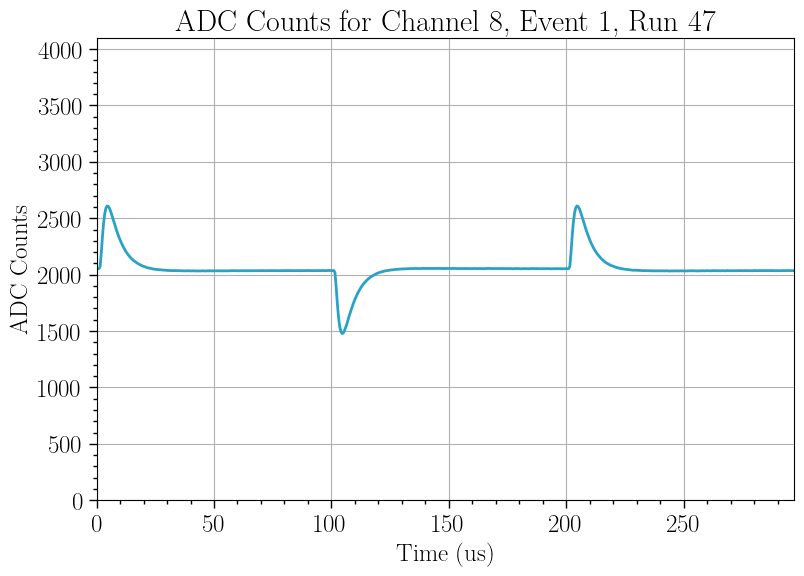

On Event 2


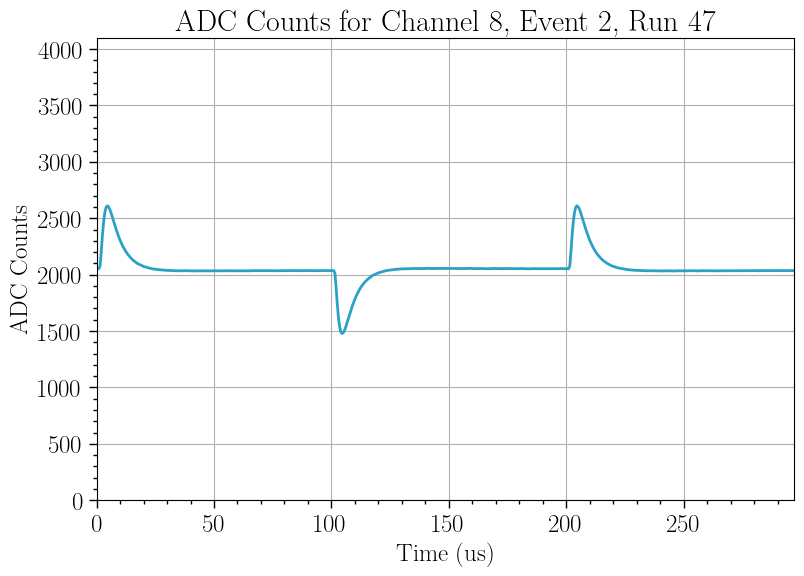

On Event 3


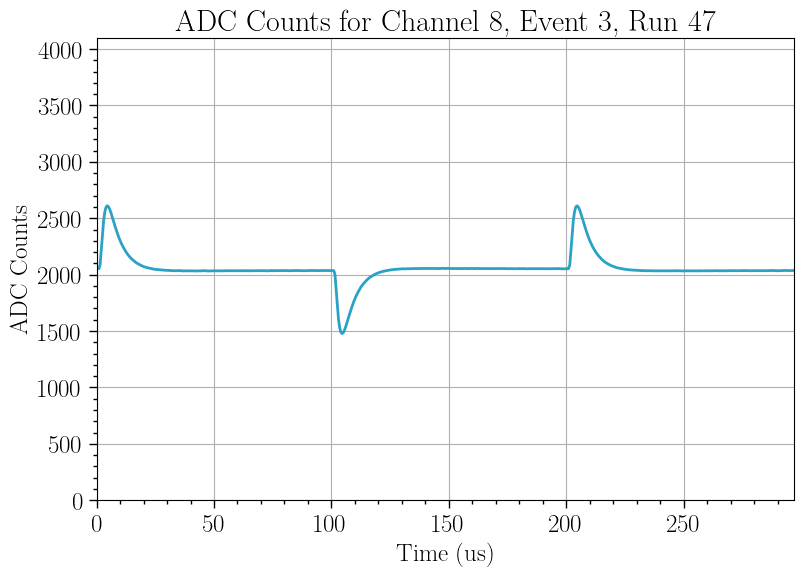

On Event 4


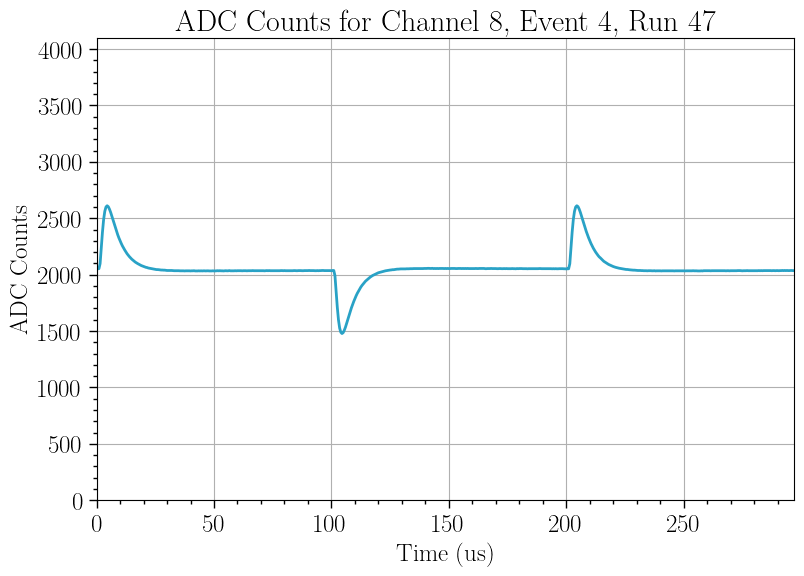

On Event 5


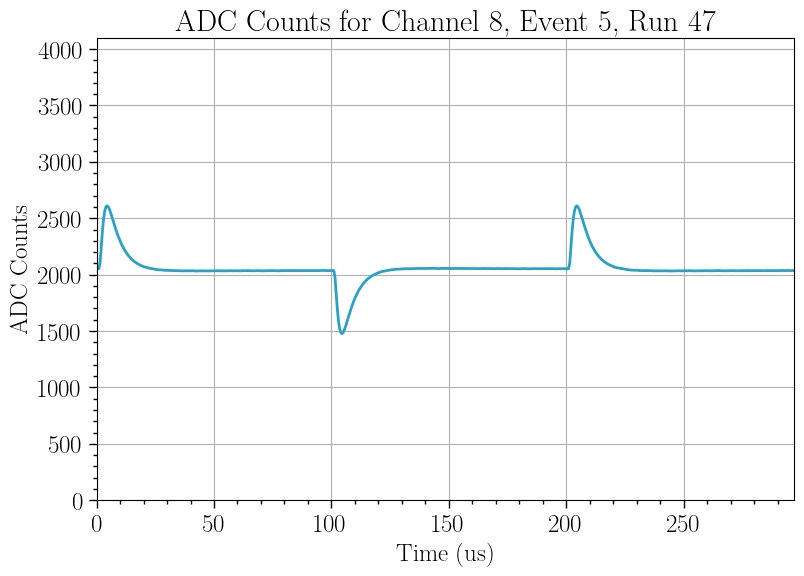

On Event 6


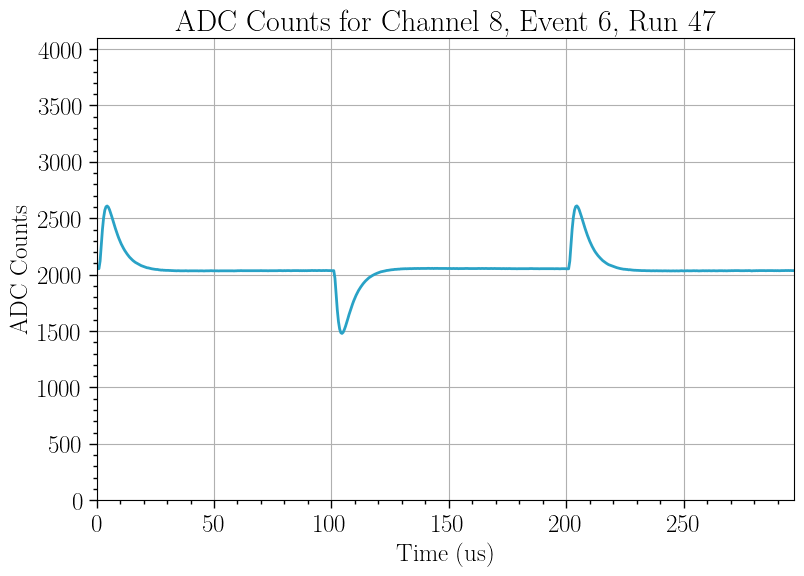

On Event 7


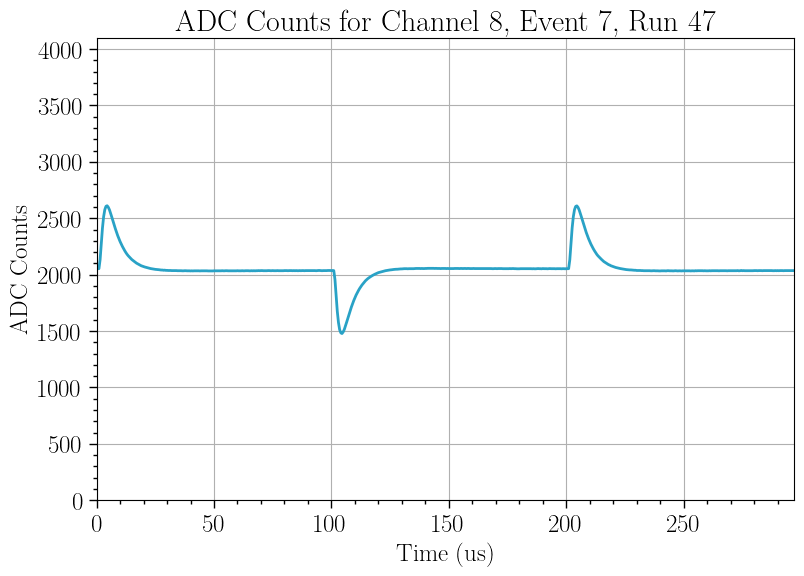

On Event 8


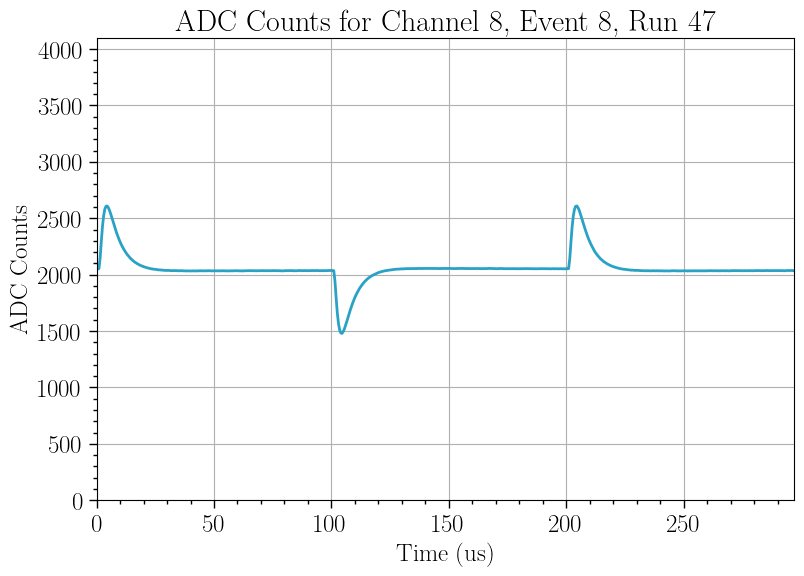

On Event 9


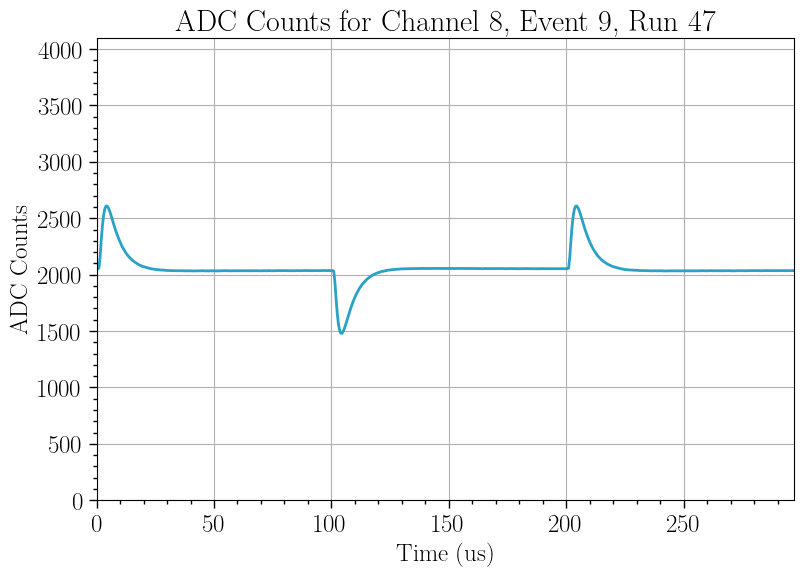

On Event 10


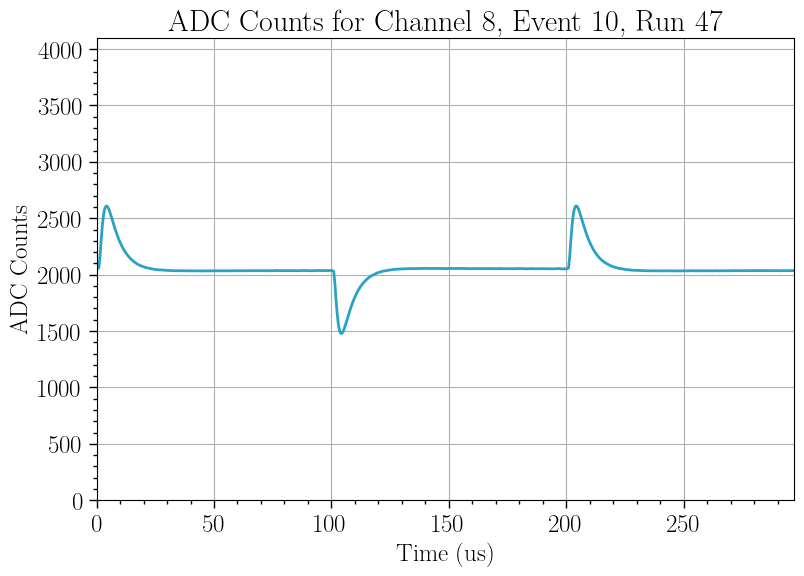

On Event 11


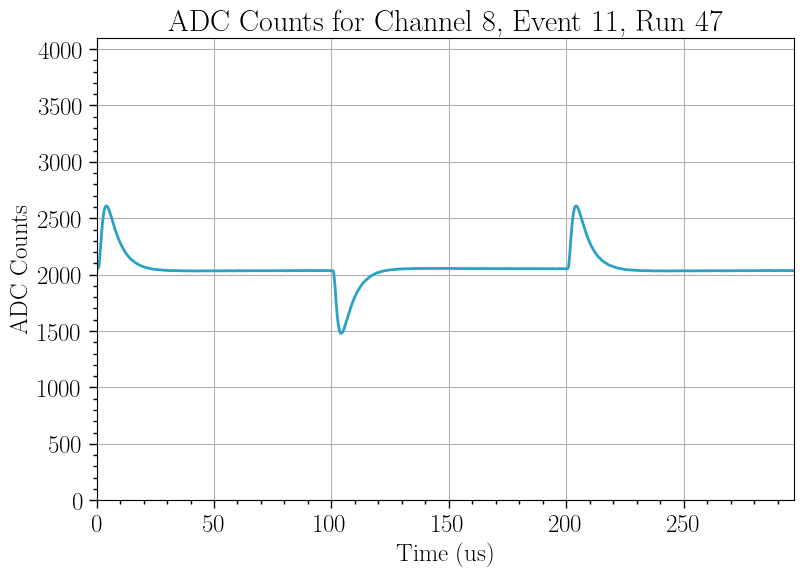

On Event 12


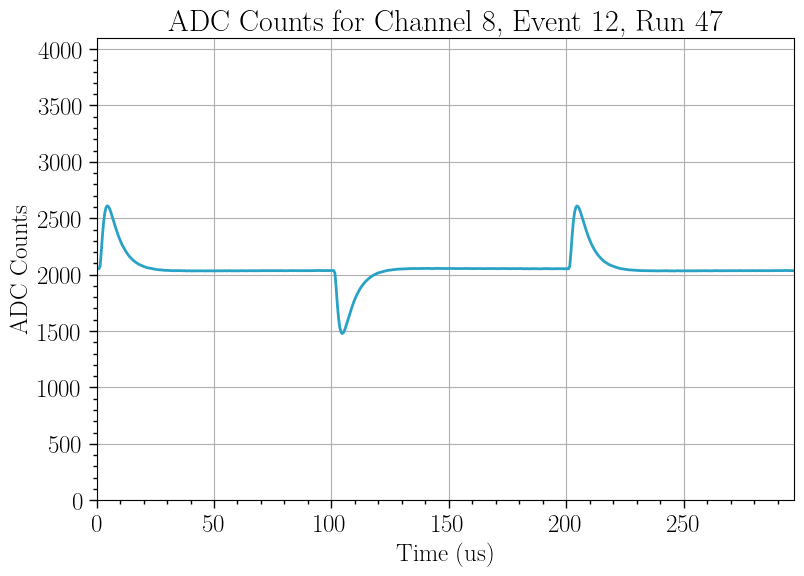

On Event 13


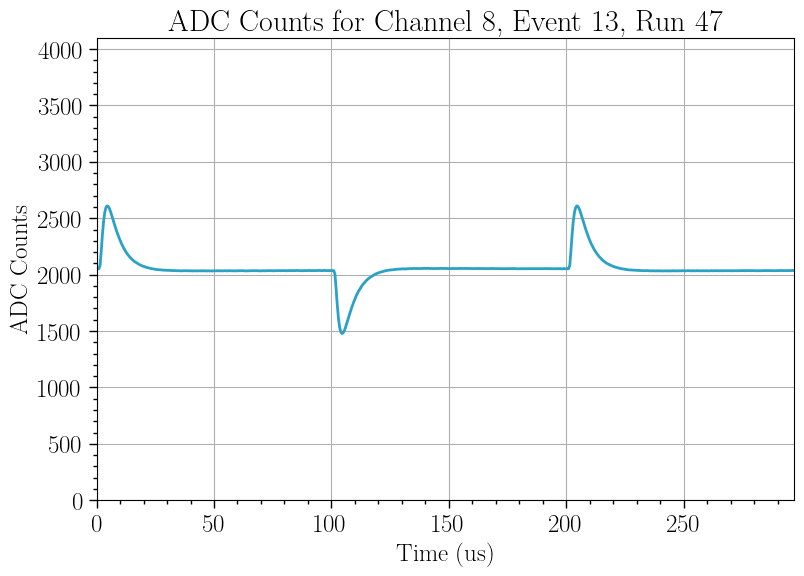

On Event 14


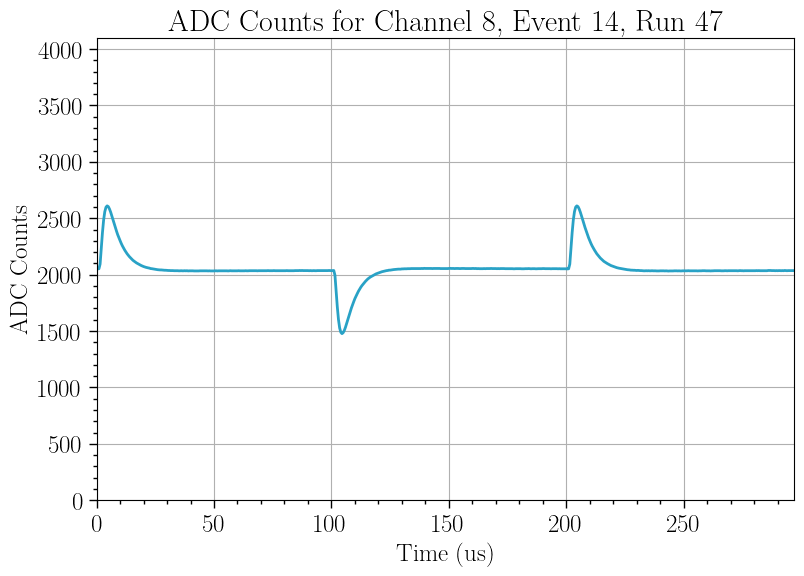

On Event 15


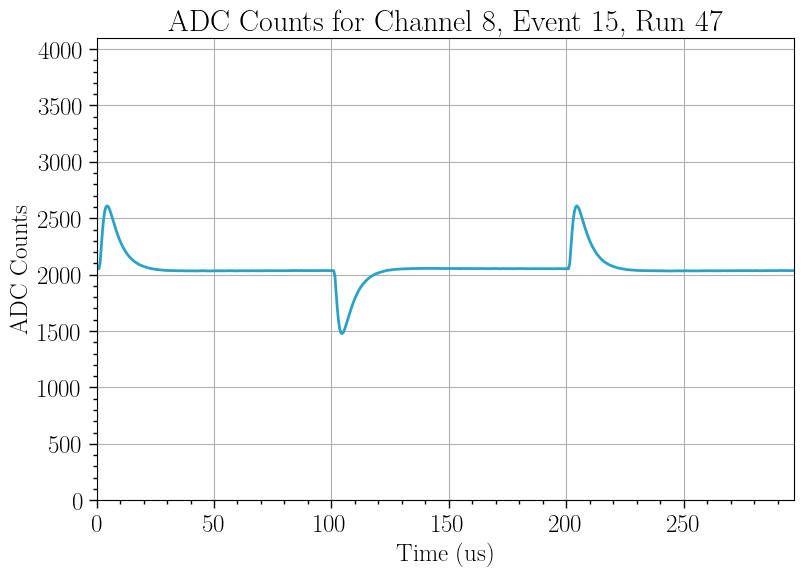

On Event 16


KeyboardInterrupt: 

In [13]:
num_of_events = 963
for i in range(1, num_of_events):
    print("On Event {}".format(i))
    plot_channel_event(file_list=[47], channel=8, event=i, disc=20, zoom=0, saveas='')

Once we've found events of interest, we can single them out and save them if needed.

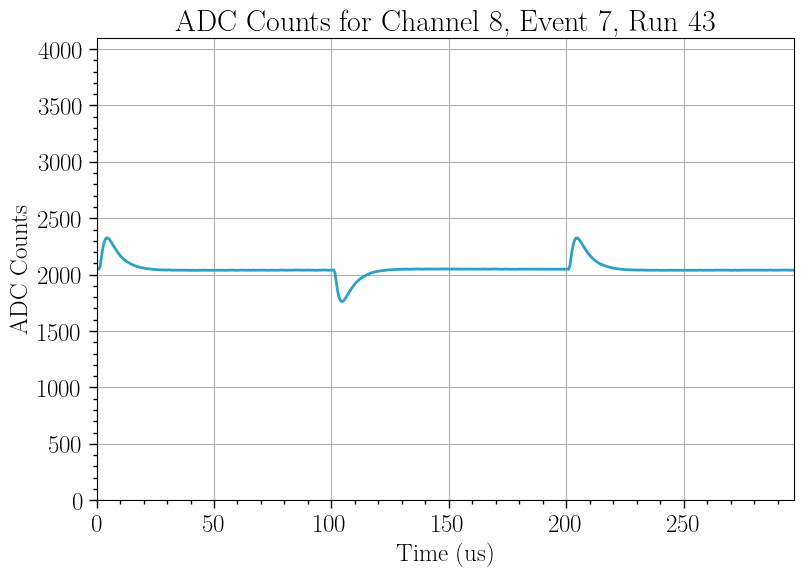

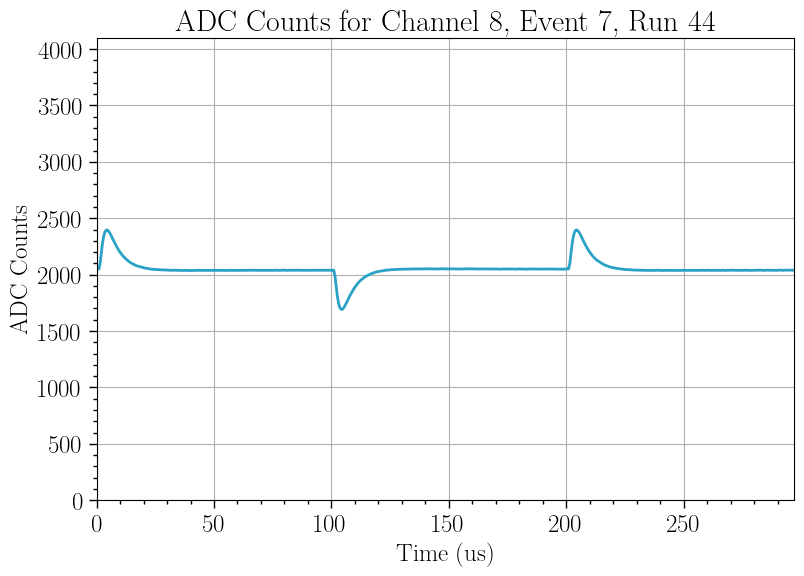

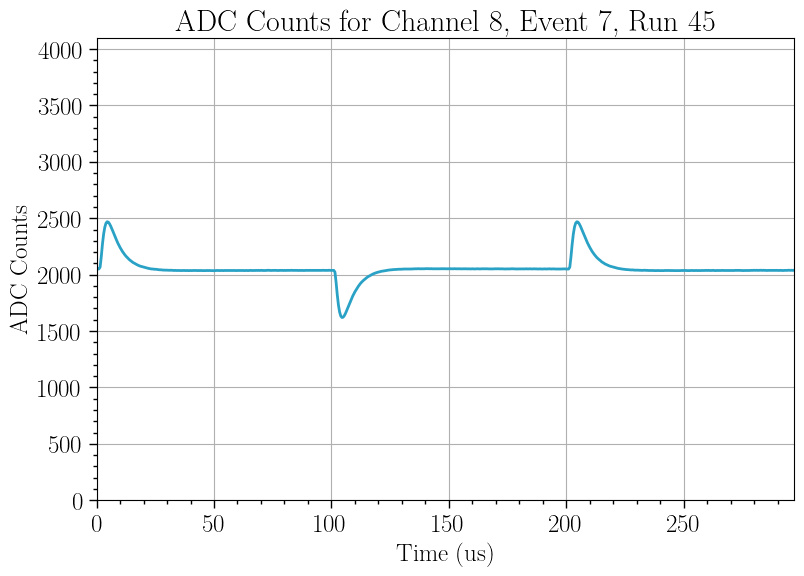

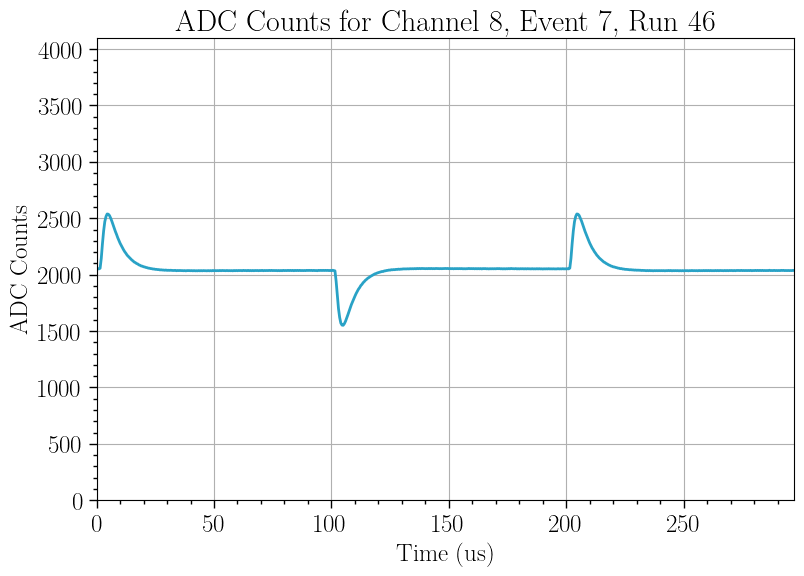

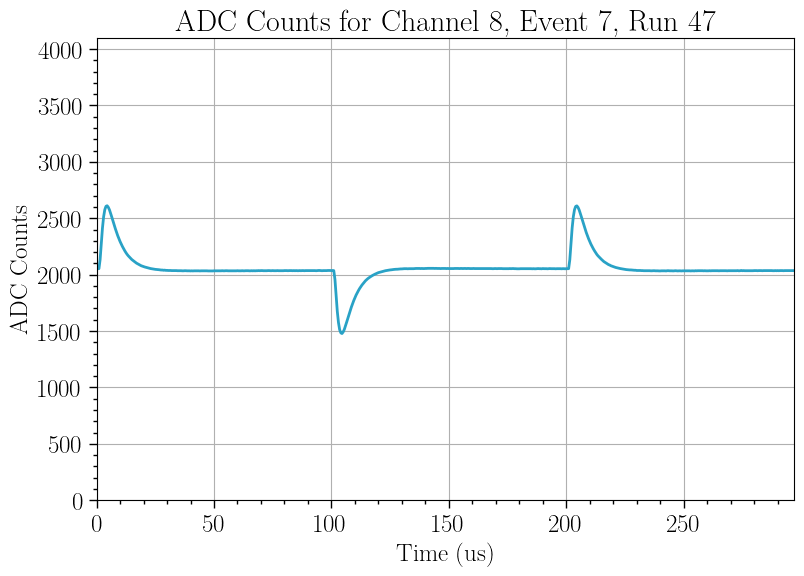

In [12]:
plot_channel_event(file_list=[43, 44, 45, 46, 47], channel=8, event=7, disc=0, zoom=0, saveas='')

### All Channels, Specific Event

In [11]:
# plots waveforms of all channels for a specific event
def plot_all_channels_for_event(file_list, event, disc=0, zoom=0, hide=False, saveas=''):
    # set baseline (0.5*4096)
    baseline=2048

    for filename in file_list:
        chs=[]
        inds = change_inds[filename]
        df = df_dict[filename]
        nsamps = inds[1][1]
        sum_counts = np.zeros(nsamps)
        sum_squares = np.zeros(nsamps)

        # create time axis (2 MHz sampling rate -> 0.5 us steps)
        time = 0.5*np.arange(nsamps)
        
        selected_samples = select_all_channels_for_event(df, inds, event)
        for i in range(len(selected_samples)-1):
            adc_counts = selected_samples[i+1]['adc_count']
            if(len(adc_counts)!=nsamps):
                print('Ch: {} Event: {} Found missing adc counts. {} instead of {}'.format(i+1, event, len(adc_counts), nsamps))
                continue
            # if discrimination is nonzero and counts are below threshold, skip plotting this event for all channels
            if disc!=0 and np.max(np.abs(adc_counts.values-baseline))<(disc):
                continue
            else:
                chs.append(i)
                
        # otherwise, if we are above threshold we want to plot all channels for this event
        if chs:
            plt.figure(figsize=[8,6])
            if hide and disc!=0: 
                [plt.plot(time, selected_samples[i+1]['adc_count'].values,  label=f'Ch. {i+1}') for i in chs]
                plt.legend(loc='best')
            else:[plt.plot(time, selected_samples[i+1]['adc_count'].values) for i in range(len(selected_samples)-1)]
            #plt.fill_between(time, average_counts - std_deviation, average_counts + std_deviation, color = colors[0], alpha=0.3, label='Std Dev')
            plt.title(f'ADC Counts for Event {event}, Run {filename}')
            plt.xlabel('Time (us)')
            plt.ylabel('ADC Counts')
            plt.xlim(time.min(), time.max())
            if zoom!=0: plt.ylim(baseline-zoom, baseline+zoom)
            else: plt.ylim(0, 4096)
            plt.grid(True)
            if saveas: plt.savefig(f'{savedir}/ADCCounts_Event{event}Run{filename}.{saveas}', dpi=400, bbox_inches='tight')
            plt.show()    
            
    return

**`plot_all_channels_for_event()` takes the following inputs:**
- `file_list`: list of runs
- `event`: event number
- `disc`: discriminator threshold; set to 0 for no discriminator
- `zoom`:y-axis zoom. `zoom=100` means the y-axis will range from +/-100 ADC counts about the baseline. set to zero for no zoom
- `hide`: `hide=True` hides waveforms from channels below the discriminator threshold
- `saveas`: file extension to save plot ('pdf', 'png', 'jpg', etc.). plots will be saved to `savedir`. set `save=''` for no saving

We can loop through all events using a discriminator threshold to quickly find all events with a pulse on any channel:

On Event 1
On Event 2
On Event 3
On Event 4
On Event 5
On Event 6
On Event 7
On Event 8
On Event 9
On Event 10
On Event 11
On Event 12
On Event 13
On Event 14


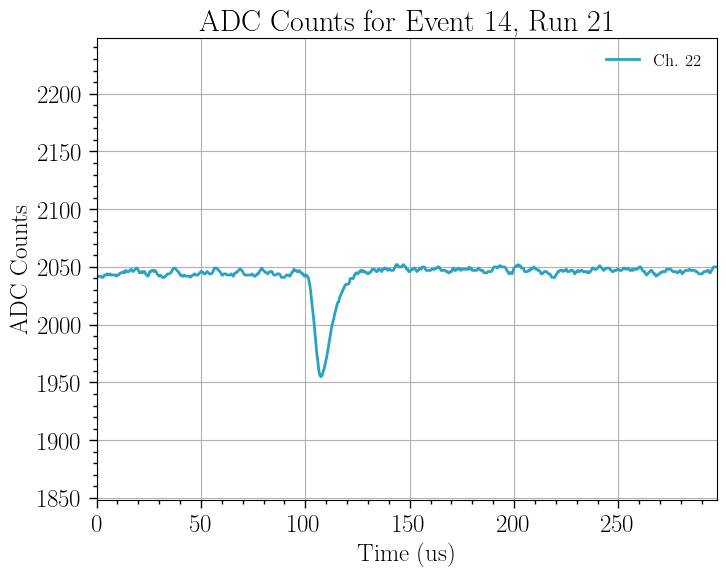

On Event 15
On Event 16
On Event 17
On Event 18
On Event 19
On Event 20
On Event 21
On Event 22
On Event 23
On Event 24
On Event 25
On Event 26
On Event 27
On Event 28


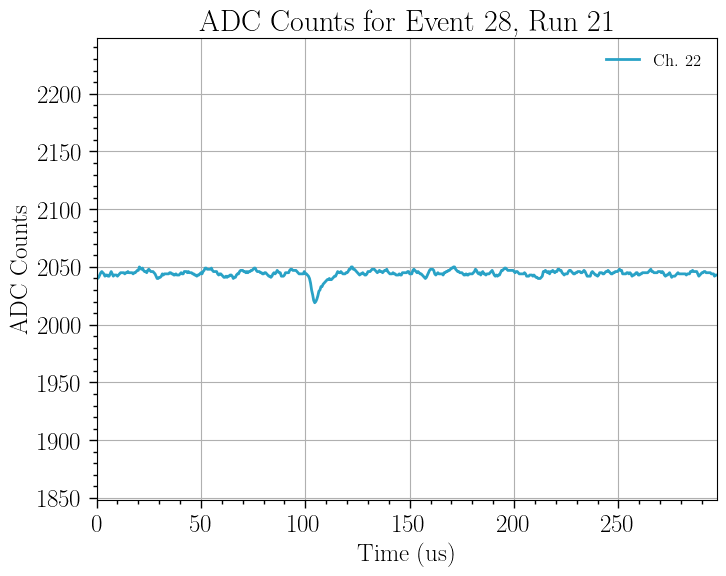

On Event 29
On Event 30
On Event 31
On Event 32
On Event 33
On Event 34
On Event 35
On Event 36
On Event 37
On Event 38


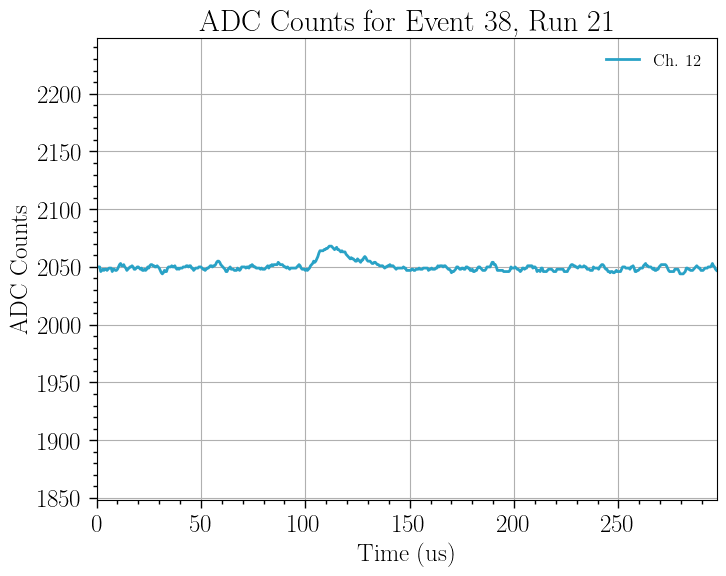

On Event 39
On Event 40
On Event 41


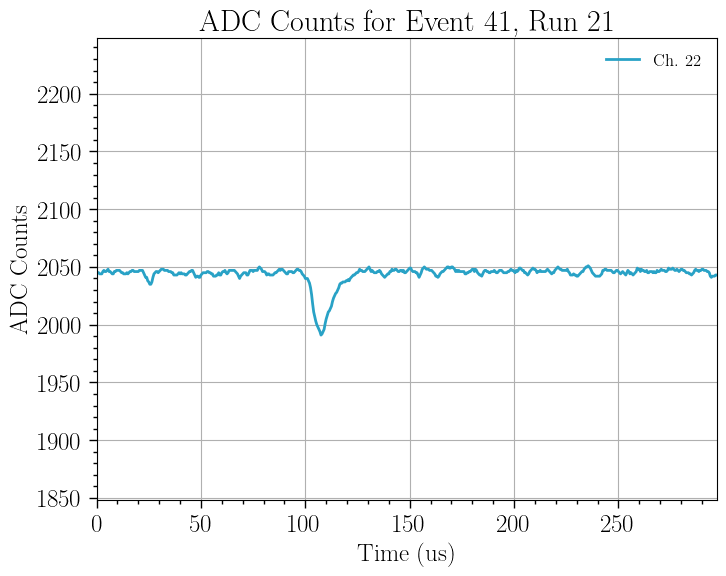

On Event 42
On Event 43
On Event 44
On Event 45
On Event 46
On Event 47
On Event 48
On Event 49
On Event 50
On Event 51
On Event 52
On Event 53
On Event 54
On Event 55
On Event 56
On Event 57
On Event 58
On Event 59
On Event 60
On Event 61
On Event 62
On Event 63


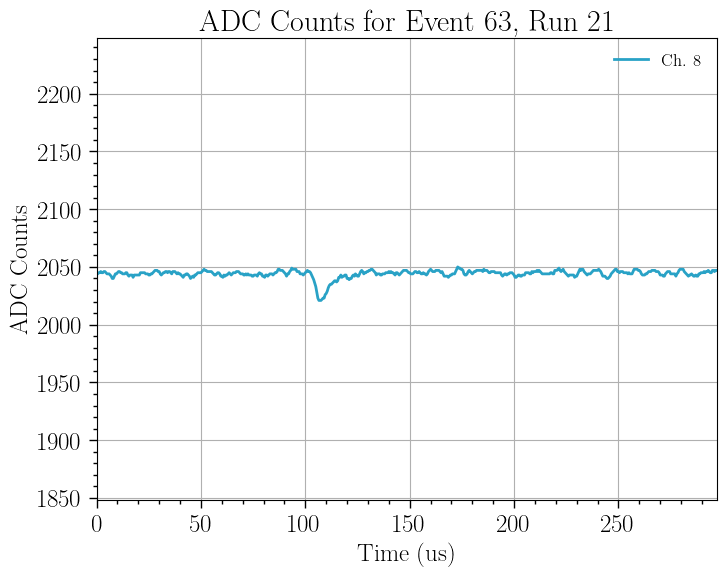

On Event 64
On Event 65
On Event 66
On Event 67


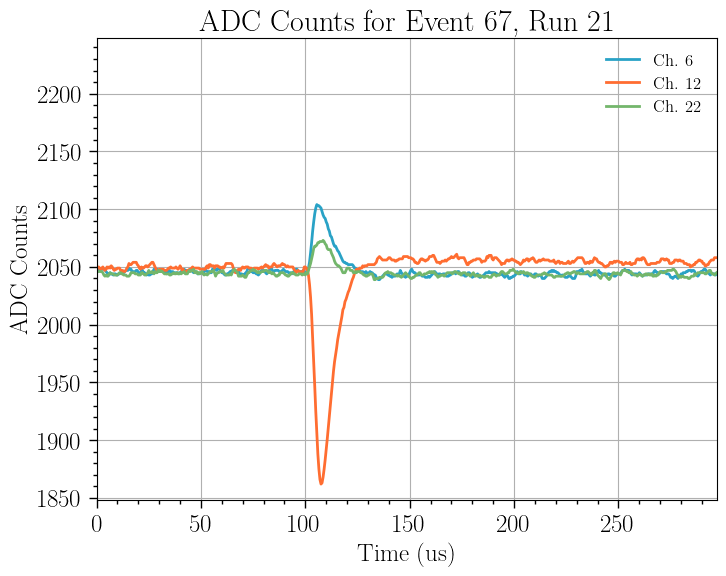

On Event 68
On Event 69
On Event 70
On Event 71
On Event 72
On Event 73
On Event 74
On Event 75
On Event 76
On Event 77
On Event 78
On Event 79
On Event 80
On Event 81
On Event 82
On Event 83
On Event 84
On Event 85
On Event 86


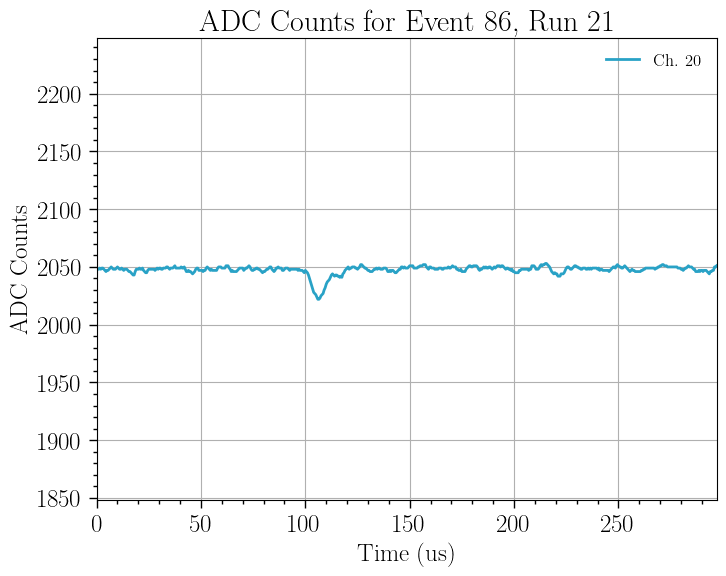

On Event 87
On Event 88
On Event 89
On Event 90
On Event 91
On Event 92
On Event 93
On Event 94
On Event 95
On Event 96
On Event 97
On Event 98
On Event 99
On Event 100


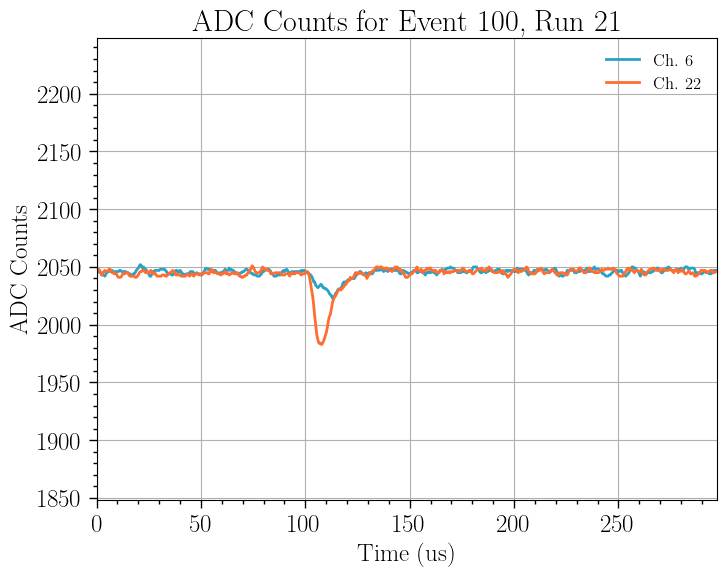

On Event 101
On Event 102
On Event 103
On Event 104
On Event 105
On Event 106
On Event 107
On Event 108
On Event 109
On Event 110
On Event 111
On Event 112
On Event 113
On Event 114
On Event 115
On Event 116
On Event 117
On Event 118
On Event 119
On Event 120
On Event 121
On Event 122
On Event 123
On Event 124


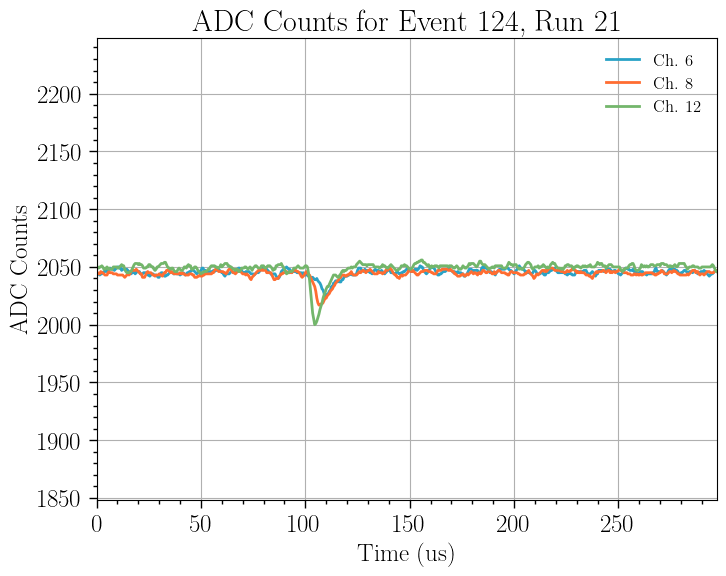

On Event 125
On Event 126
On Event 127
On Event 128


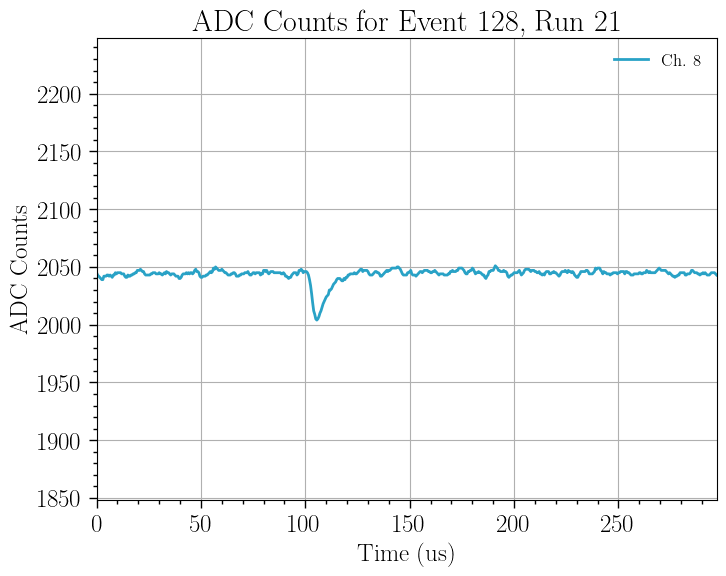

On Event 129
On Event 130
On Event 131
On Event 132
On Event 133
On Event 134
On Event 135
On Event 136


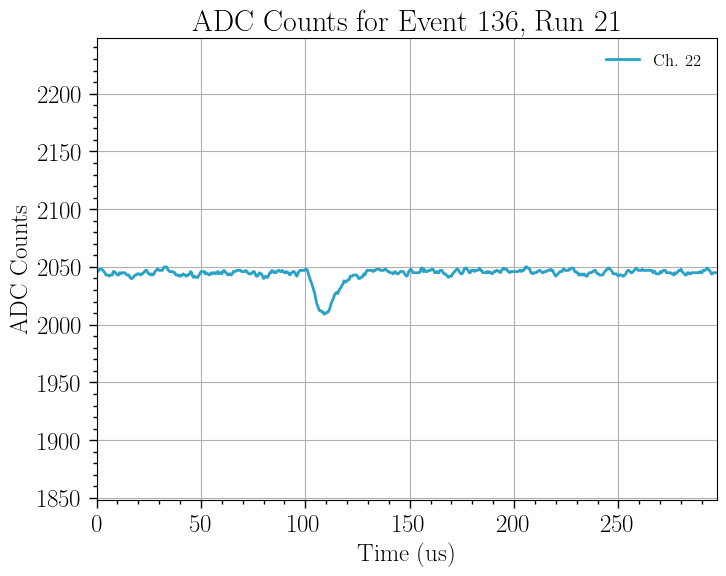

On Event 137
On Event 138
On Event 139
On Event 140
On Event 141
On Event 142
On Event 143
On Event 144
On Event 145
On Event 146
On Event 147
On Event 148
On Event 149


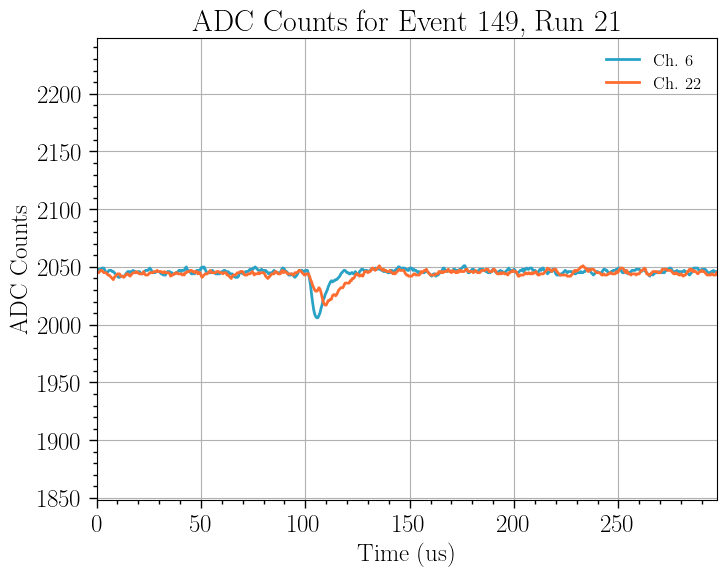

On Event 150
On Event 151
On Event 152
On Event 153
On Event 154
On Event 155
On Event 156
On Event 157


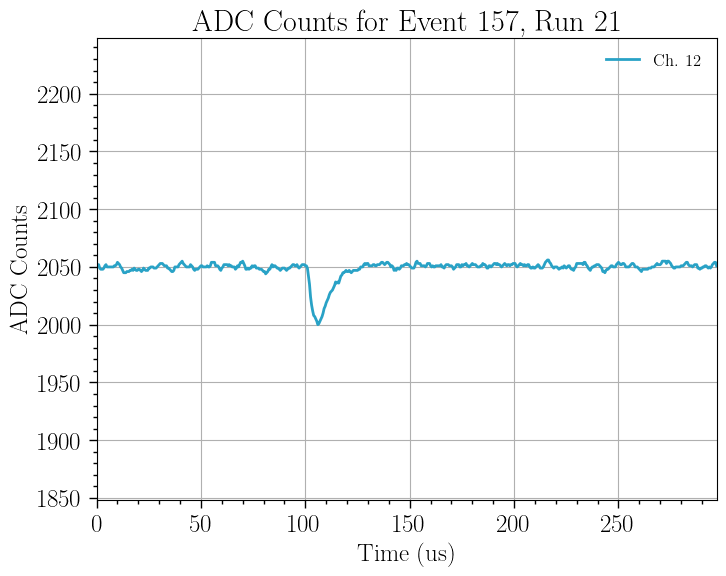

On Event 158
On Event 159
On Event 160
On Event 161
On Event 162
On Event 163
On Event 164
On Event 165
On Event 166


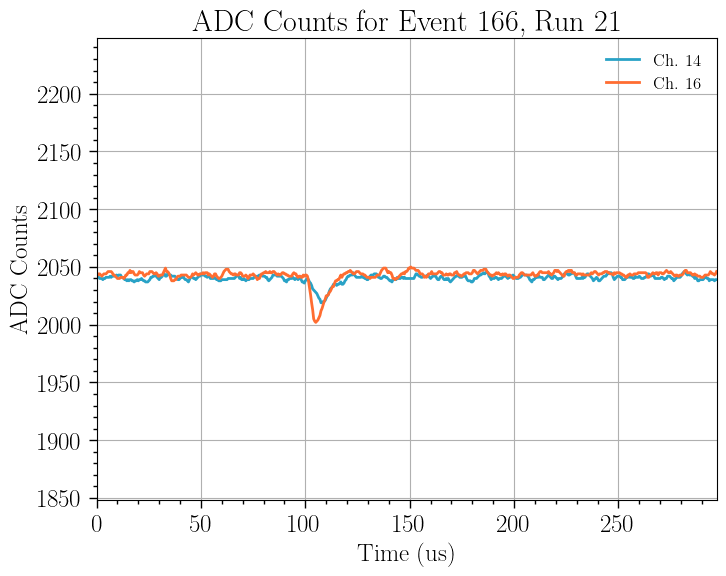

On Event 167
On Event 168
On Event 169
On Event 170
On Event 171
On Event 172
On Event 173
On Event 174
On Event 175
On Event 176
On Event 177
On Event 178
On Event 179
On Event 180
On Event 181
On Event 182


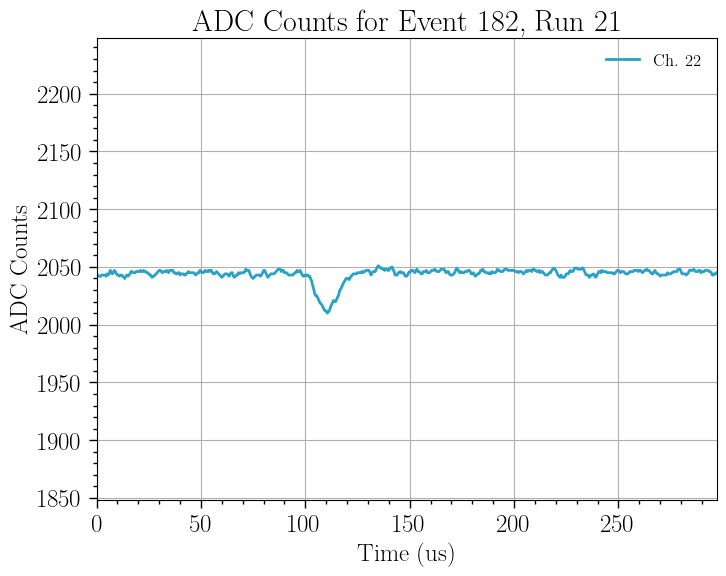

On Event 183
On Event 184
On Event 185
On Event 186
On Event 187
On Event 188
On Event 189
On Event 190


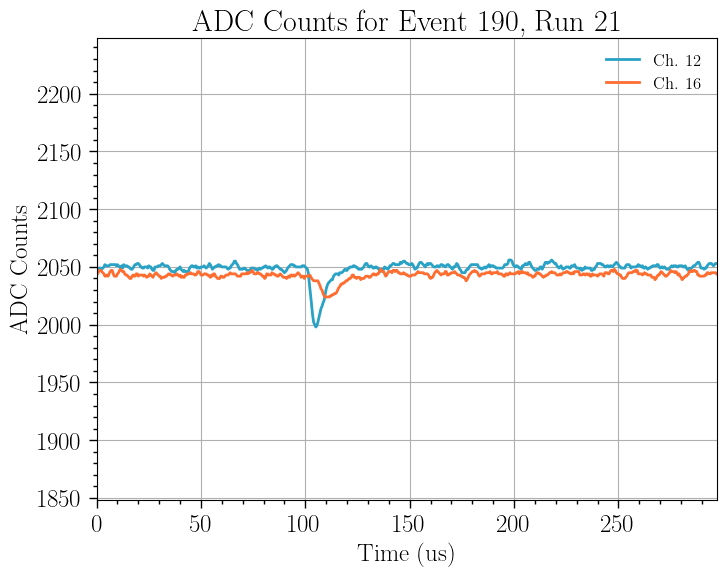

On Event 191
On Event 192
On Event 193
On Event 194
On Event 195
On Event 196
On Event 197
On Event 198
On Event 199
On Event 200
On Event 201
On Event 202
On Event 203
On Event 204
On Event 205
On Event 206
On Event 207
On Event 208
On Event 209
On Event 210
On Event 211
On Event 212
On Event 213
On Event 214
On Event 215


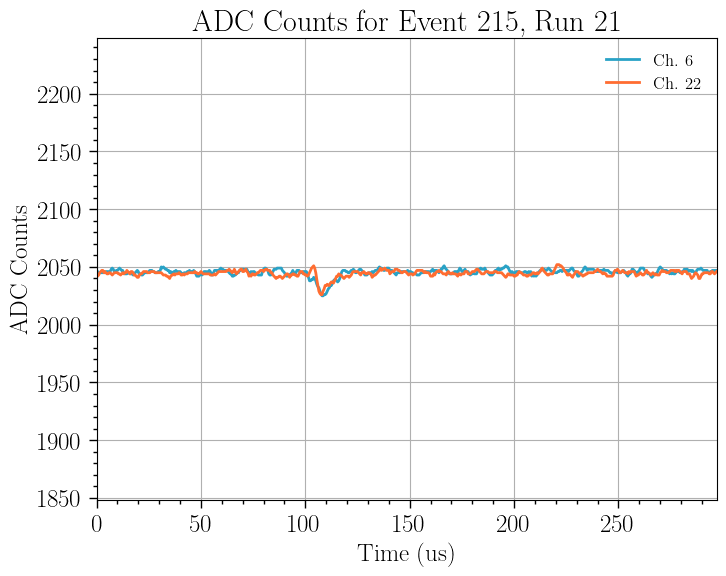

On Event 216
On Event 217
On Event 218
On Event 219
On Event 220
On Event 221
On Event 222
On Event 223
On Event 224
On Event 225
On Event 226
On Event 227
On Event 228
On Event 229
On Event 230
On Event 231
On Event 232
On Event 233
On Event 234
On Event 235
On Event 236
On Event 237
On Event 238
On Event 239
On Event 240
On Event 241
On Event 242
On Event 243
On Event 244
On Event 245
On Event 246
On Event 247
On Event 248
On Event 249
On Event 250
On Event 251
On Event 252
On Event 253
On Event 254
On Event 255
On Event 256
On Event 257
On Event 258
On Event 259
On Event 260
On Event 261
On Event 262
On Event 263
On Event 264
On Event 265
On Event 266
On Event 267
On Event 268
On Event 269
On Event 270
On Event 271
On Event 272
On Event 273
On Event 274


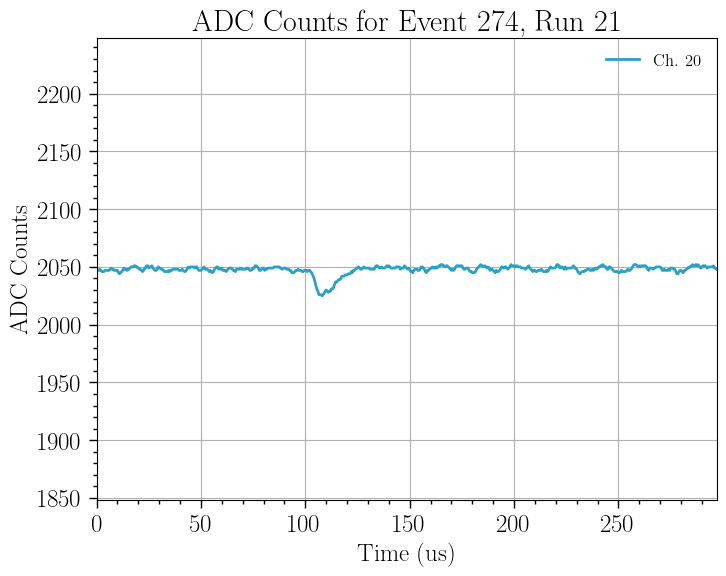

On Event 275
On Event 276
On Event 277
On Event 278
On Event 279
On Event 280
On Event 281


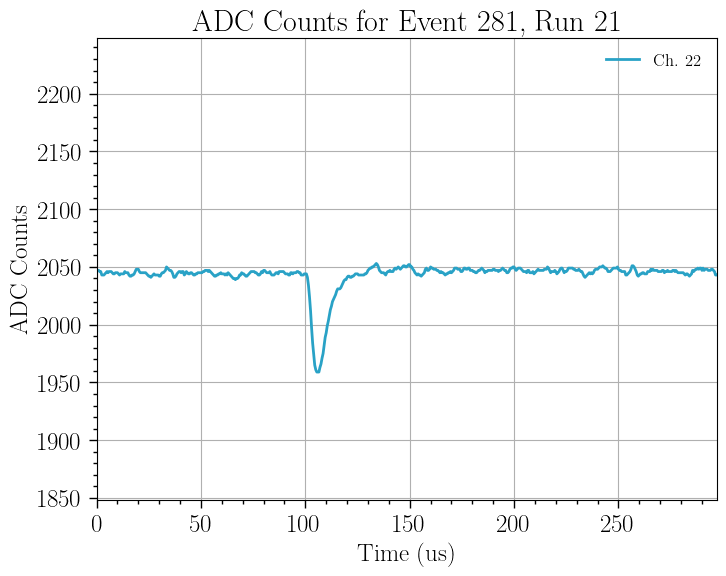

On Event 282
On Event 283
On Event 284
On Event 285
On Event 286
On Event 287
On Event 288
On Event 289
On Event 290
On Event 291
On Event 292
On Event 293
On Event 294
On Event 295
On Event 296
On Event 297
On Event 298
On Event 299
On Event 300
On Event 301
On Event 302
On Event 303
On Event 304
On Event 305
On Event 306
On Event 307
On Event 308
On Event 309
On Event 310
On Event 311
On Event 312


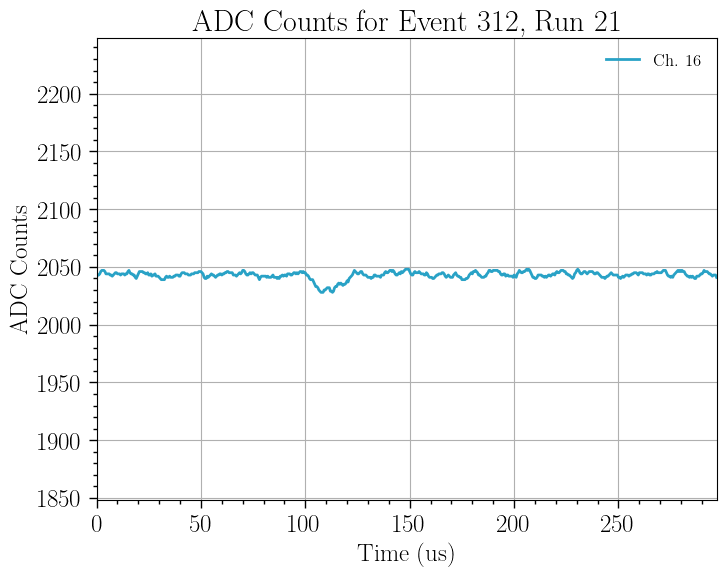

On Event 313
On Event 314
On Event 315
On Event 316
On Event 317
On Event 318
On Event 319
On Event 320
On Event 321
On Event 322
On Event 323
On Event 324
On Event 325
On Event 326
On Event 327
On Event 328
On Event 329
On Event 330
On Event 331
On Event 332
On Event 333
On Event 334
On Event 335
On Event 336
On Event 337
On Event 338
On Event 339
On Event 340
On Event 341
On Event 342
On Event 343
On Event 344
On Event 345
On Event 346
On Event 347
On Event 348
On Event 349
On Event 350
On Event 351
On Event 352
On Event 353
On Event 354
On Event 355
On Event 356
On Event 357
On Event 358
On Event 359
On Event 360
On Event 361
On Event 362
On Event 363
On Event 364
On Event 365
On Event 366
On Event 367
On Event 368
On Event 369
On Event 370
On Event 371
On Event 372
On Event 373
On Event 374
On Event 375
On Event 376
On Event 377
On Event 378
On Event 379
On Event 380
On Event 381
On Event 382
On Event 383
On Event 384
On Event 385
On Event 386


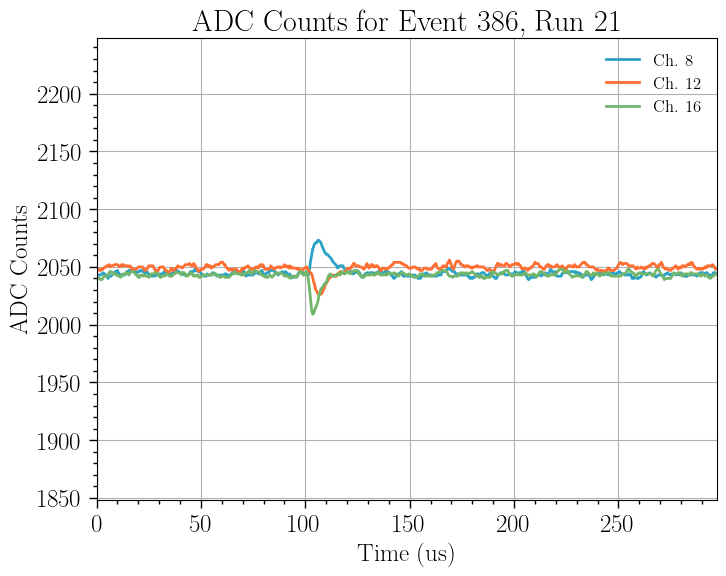

On Event 387
On Event 388


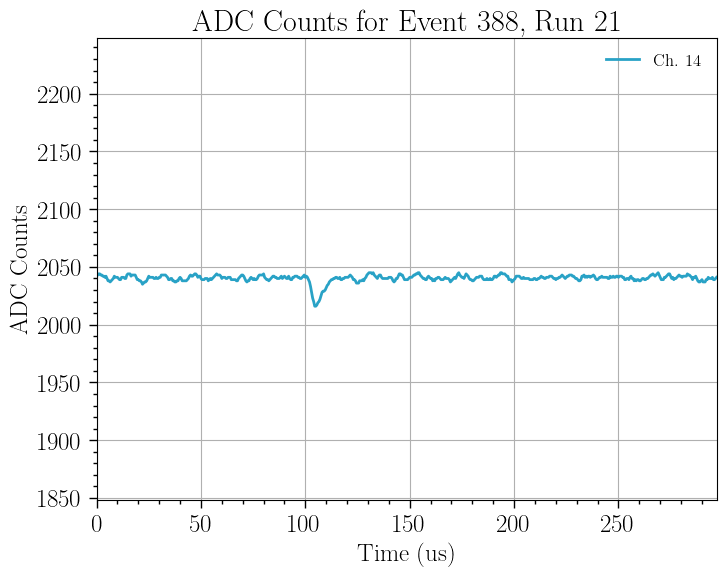

On Event 389
On Event 390
On Event 391
On Event 392
On Event 393
On Event 394
On Event 395
On Event 396
On Event 397
On Event 398
On Event 399
On Event 400
On Event 401
On Event 402
On Event 403
On Event 404
On Event 405
On Event 406
On Event 407
On Event 408
On Event 409
On Event 410
On Event 411
On Event 412
On Event 413
On Event 414
On Event 415
On Event 416
On Event 417
On Event 418
On Event 419
On Event 420
On Event 421
On Event 422
On Event 423
On Event 424
On Event 425
On Event 426
On Event 427


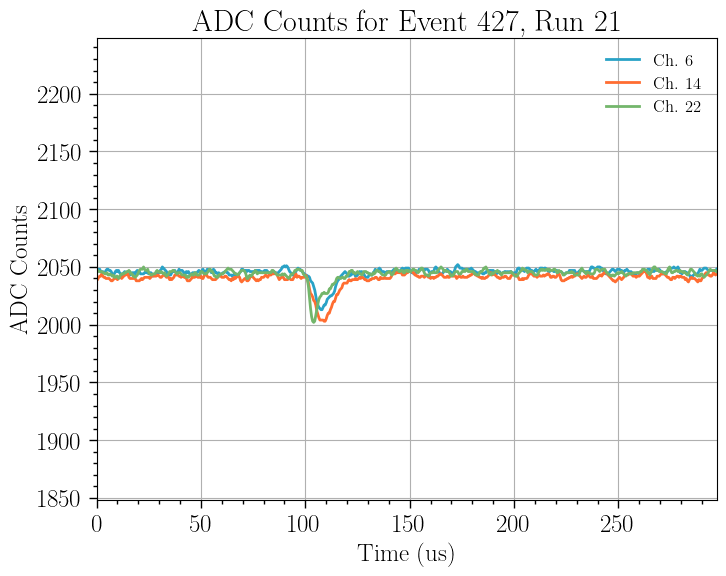

On Event 428
On Event 429
On Event 430
On Event 431
On Event 432
On Event 433
On Event 434
On Event 435
On Event 436
On Event 437
On Event 438
On Event 439
On Event 440
On Event 441


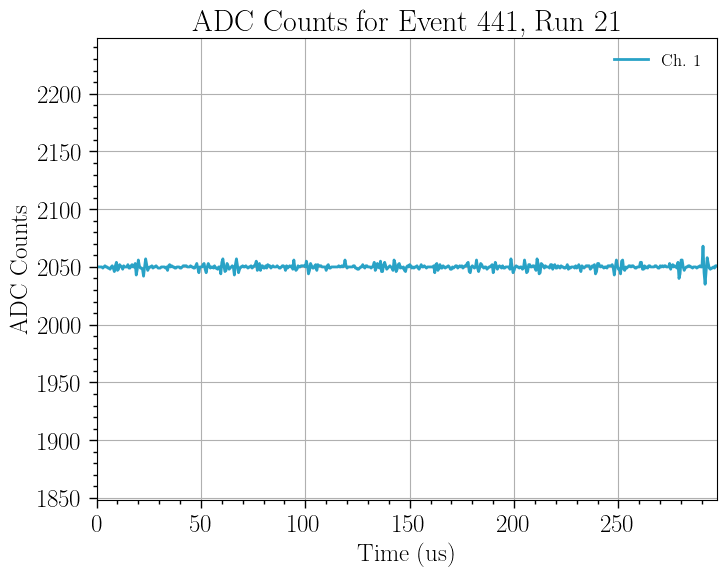

On Event 442
On Event 443
On Event 444
On Event 445
On Event 446
On Event 447
On Event 448
On Event 449
On Event 450
On Event 451
On Event 452
On Event 453
On Event 454
On Event 455
On Event 456
On Event 457
On Event 458
On Event 459
On Event 460
On Event 461
On Event 462
On Event 463
On Event 464
On Event 465


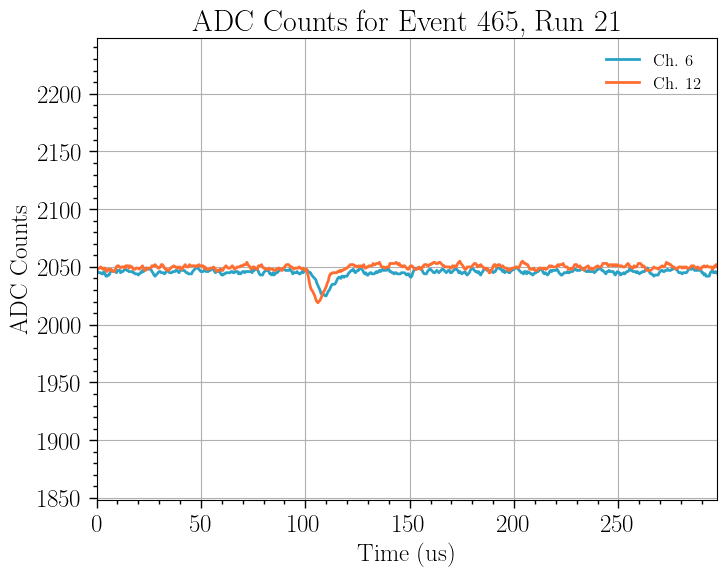

On Event 466


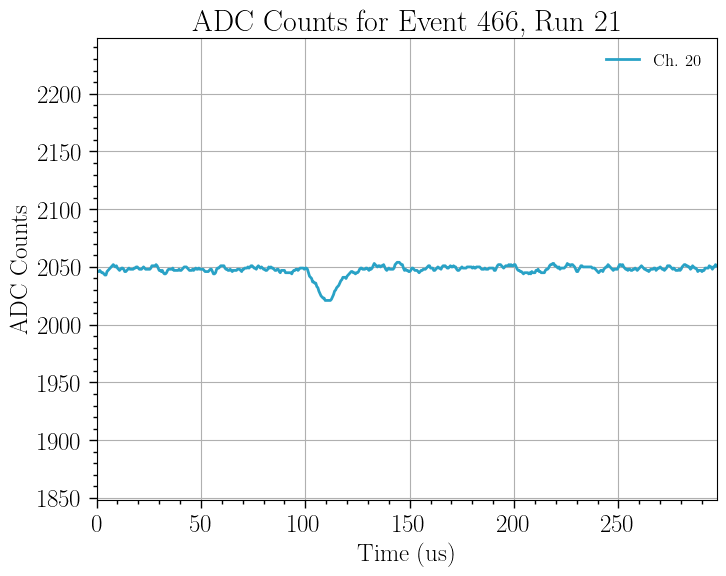

On Event 467
On Event 468
On Event 469
On Event 470
On Event 471
On Event 472
On Event 473
On Event 474
On Event 475
On Event 476
On Event 477
On Event 478
On Event 479
On Event 480


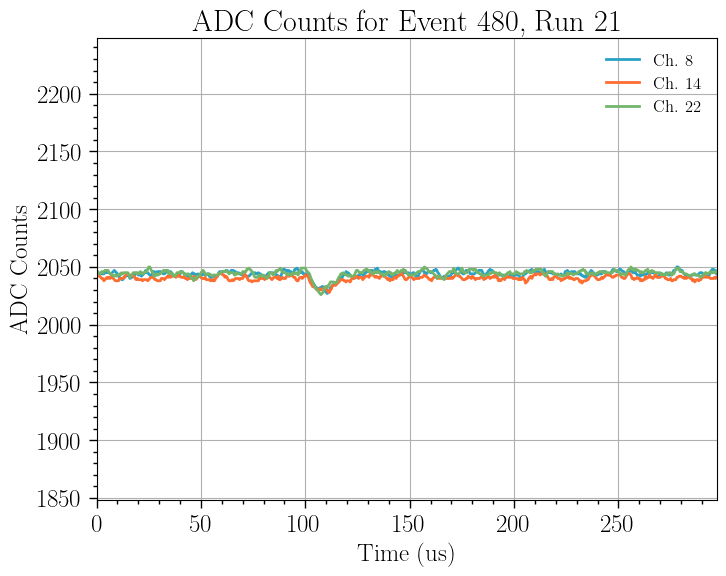

On Event 481
On Event 482
On Event 483
On Event 484
On Event 485
On Event 486
On Event 487
On Event 488
On Event 489
On Event 490
On Event 491
On Event 492
On Event 493
On Event 494
On Event 495
On Event 496
On Event 497
On Event 498
On Event 499
On Event 500
On Event 501
On Event 502
On Event 503
On Event 504
On Event 505
On Event 506
On Event 507
On Event 508
On Event 509
On Event 510
On Event 511
On Event 512
On Event 513
On Event 514
On Event 515


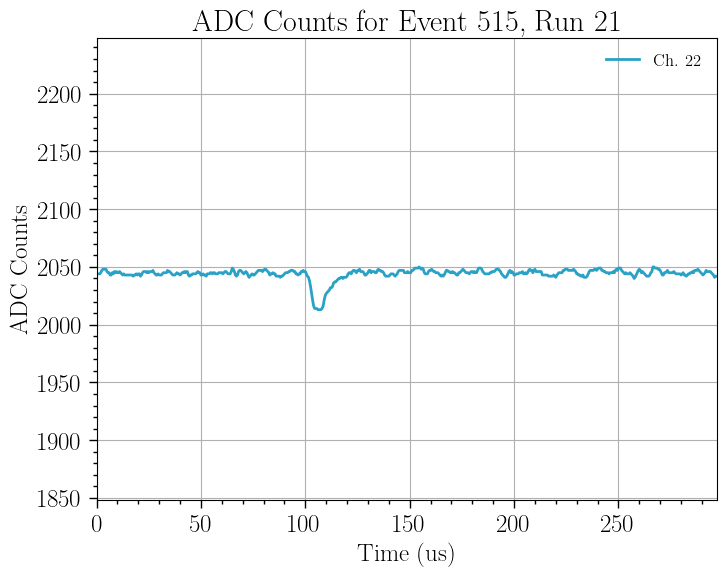

On Event 516
On Event 517
On Event 518
On Event 519
On Event 520
On Event 521
On Event 522


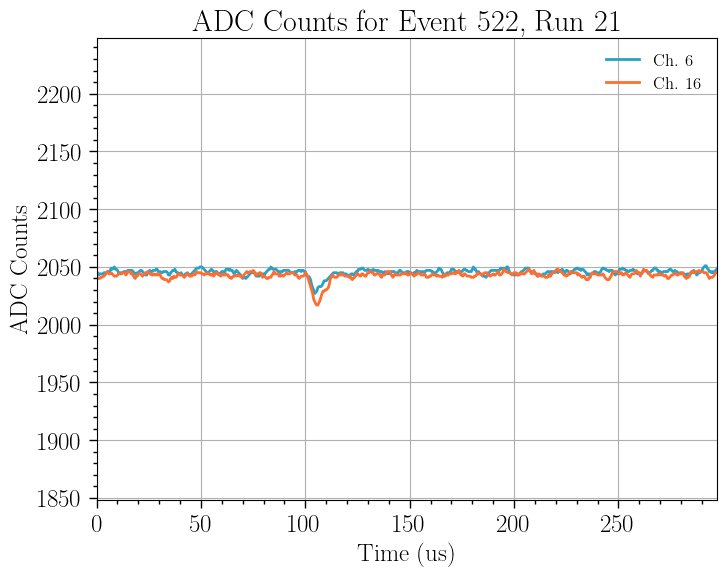

On Event 523
On Event 524
On Event 525


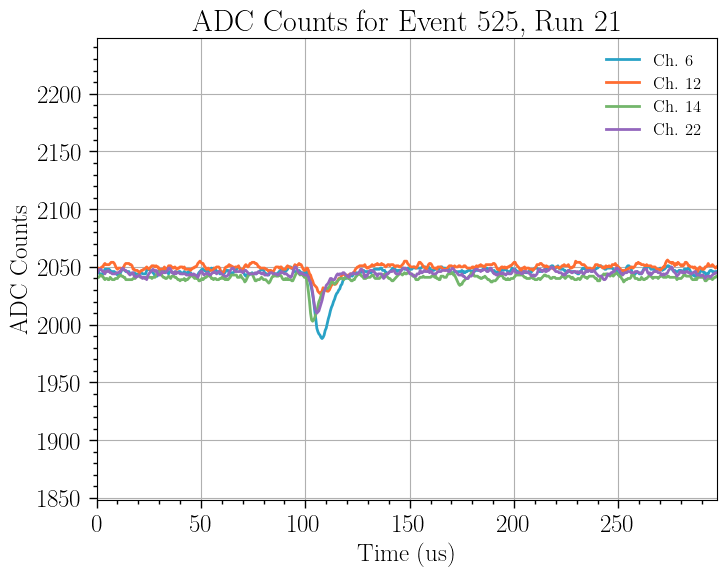

On Event 526
On Event 527
On Event 528
On Event 529
On Event 530
On Event 531
On Event 532
On Event 533
On Event 534
On Event 535
On Event 536
On Event 537
On Event 538
On Event 539
On Event 540
On Event 541
On Event 542
On Event 543


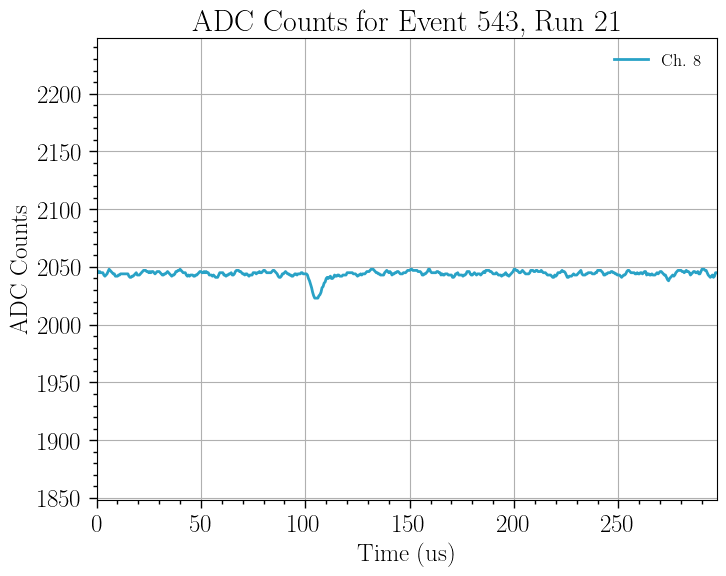

On Event 544
On Event 545
On Event 546


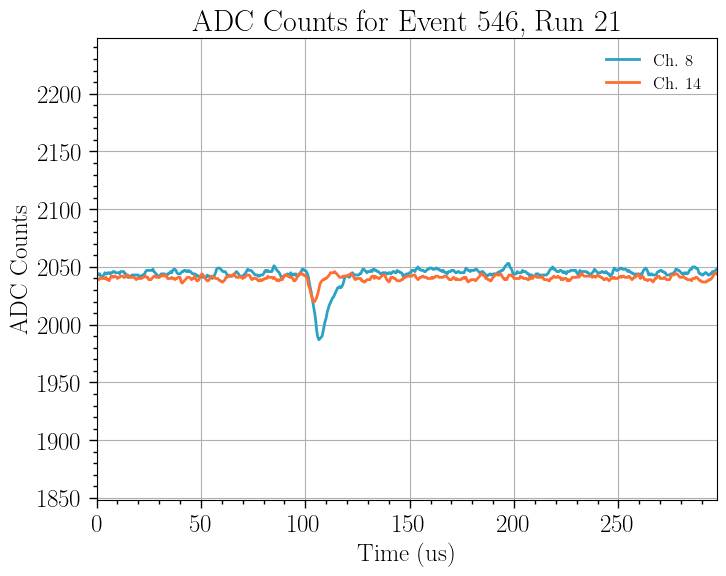

On Event 547
On Event 548
On Event 549
On Event 550
On Event 551
On Event 552


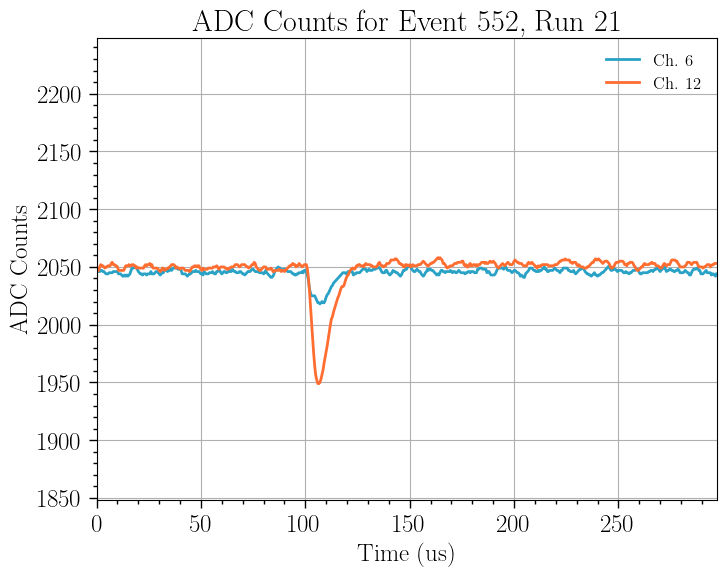

On Event 553
On Event 554


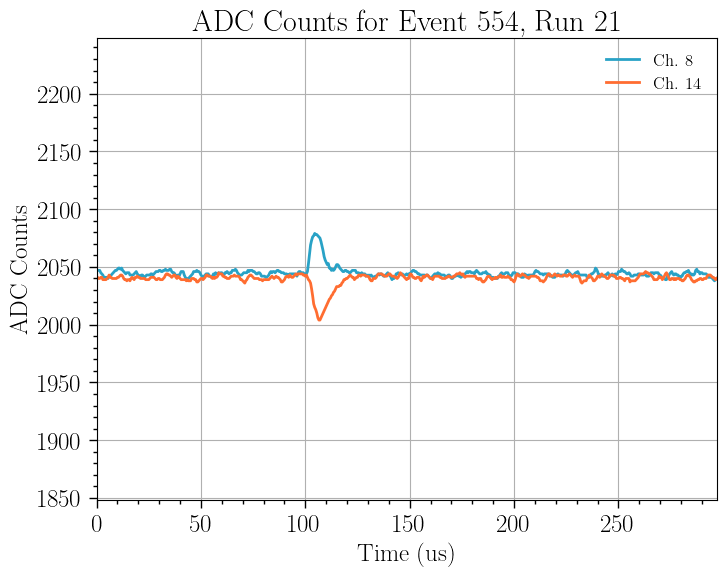

On Event 555
On Event 556
On Event 557
On Event 558
On Event 559
On Event 560
On Event 561
On Event 562
On Event 563
On Event 564
On Event 565
On Event 566
On Event 567
On Event 568
On Event 569
On Event 570
On Event 571
On Event 572
On Event 573


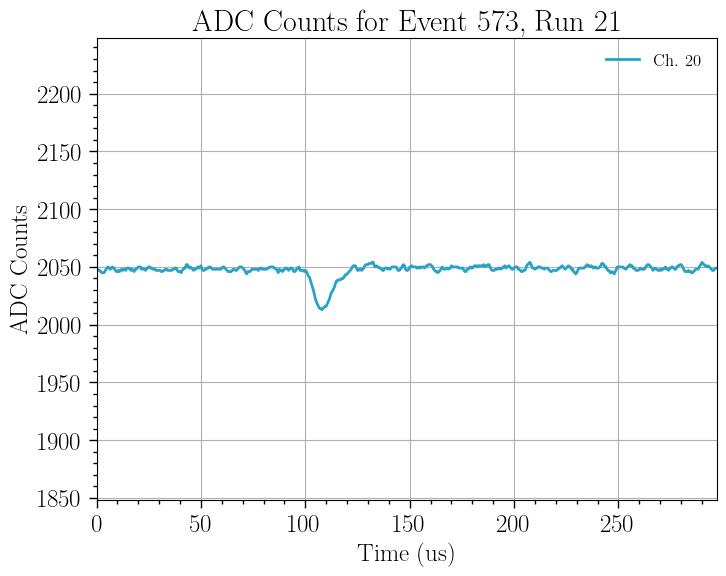

On Event 574
On Event 575
On Event 576
On Event 577
On Event 578
On Event 579
On Event 580
On Event 581
On Event 582
On Event 583
On Event 584
On Event 585
On Event 586
On Event 587
On Event 588
On Event 589
On Event 590
On Event 591
On Event 592
On Event 593
On Event 594
On Event 595
On Event 596
On Event 597
On Event 598
On Event 599
On Event 600
On Event 601
On Event 602
On Event 603
On Event 604
On Event 605
On Event 606
On Event 607
On Event 608
On Event 609
On Event 610
On Event 611
On Event 612
On Event 613
On Event 614
On Event 615
On Event 616
On Event 617
On Event 618
On Event 619
On Event 620
On Event 621
On Event 622


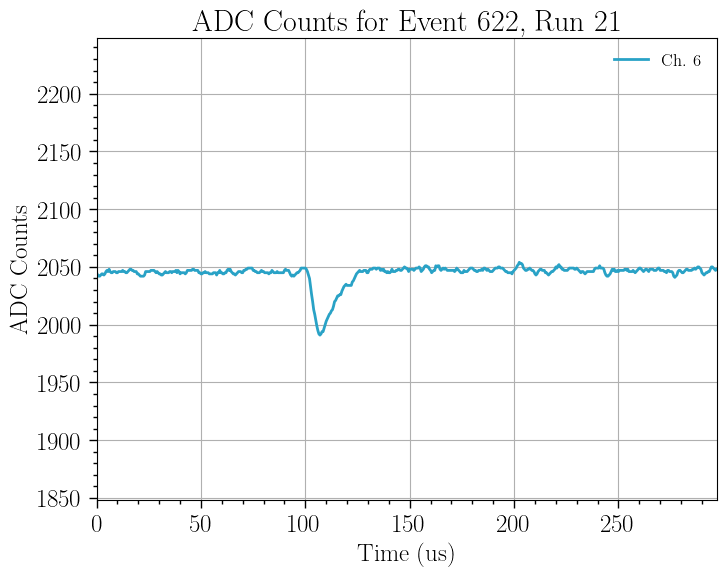

On Event 623
On Event 624
On Event 625
On Event 626
On Event 627
On Event 628
On Event 629
On Event 630
On Event 631
On Event 632
On Event 633
On Event 634
On Event 635
On Event 636
On Event 637
On Event 638
On Event 639
On Event 640
On Event 641
On Event 642


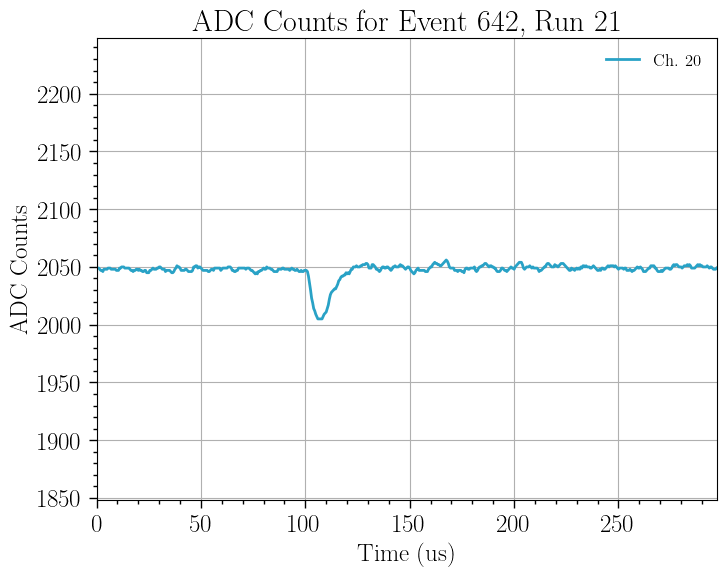

On Event 643
On Event 644
On Event 645
On Event 646
On Event 647
On Event 648
On Event 649
On Event 650
On Event 651
On Event 652
On Event 653
On Event 654
On Event 655
On Event 656
On Event 657
On Event 658
On Event 659
On Event 660
On Event 661
On Event 662
On Event 663
On Event 664
On Event 665
On Event 666
On Event 667
On Event 668
On Event 669
On Event 670


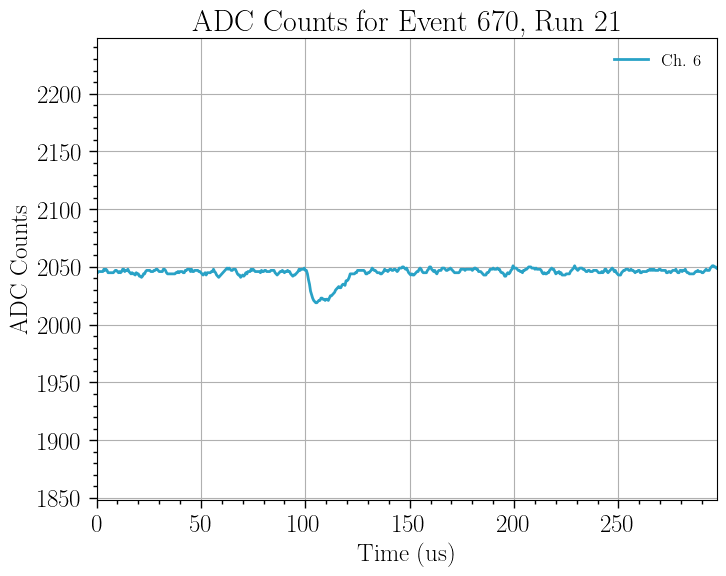

On Event 671
On Event 672
On Event 673
On Event 674
On Event 675
On Event 676
On Event 677
On Event 678
On Event 679
On Event 680
On Event 681
On Event 682
On Event 683
On Event 684
On Event 685
On Event 686
On Event 687
On Event 688
On Event 689
On Event 690
On Event 691
On Event 692
On Event 693
On Event 694
On Event 695
On Event 696
On Event 697
On Event 698
On Event 699
On Event 700
On Event 701
On Event 702
On Event 703
On Event 704
On Event 705
On Event 706
On Event 707
On Event 708
On Event 709
On Event 710
On Event 711
On Event 712
On Event 713
On Event 714
On Event 715
On Event 716
On Event 717
On Event 718
On Event 719
On Event 720
On Event 721
On Event 722
On Event 723
On Event 724
On Event 725
On Event 726
On Event 727
On Event 728
On Event 729
On Event 730
On Event 731
On Event 732
On Event 733
On Event 734
On Event 735
On Event 736
On Event 737
On Event 738
On Event 739
On Event 740
On Event 741
On Event 742
On Event 743
On Event 744
On Event 745
On Event 746
On Event 747

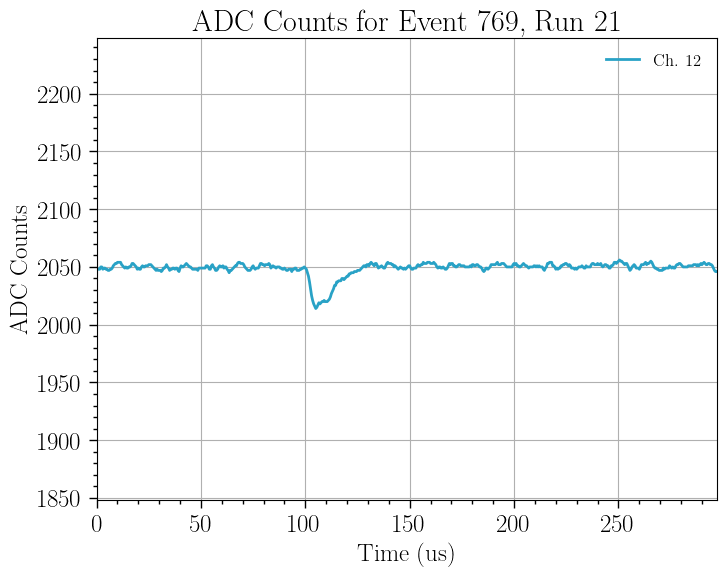

On Event 770
On Event 771
On Event 772
On Event 773
On Event 774
Ch: 96 Event: 774 Found missing adc counts. 1190 instead of 595
On Event 775
On Event 776
On Event 777
On Event 778
On Event 779
On Event 780
On Event 781
On Event 782
On Event 783
On Event 784
On Event 785
On Event 786


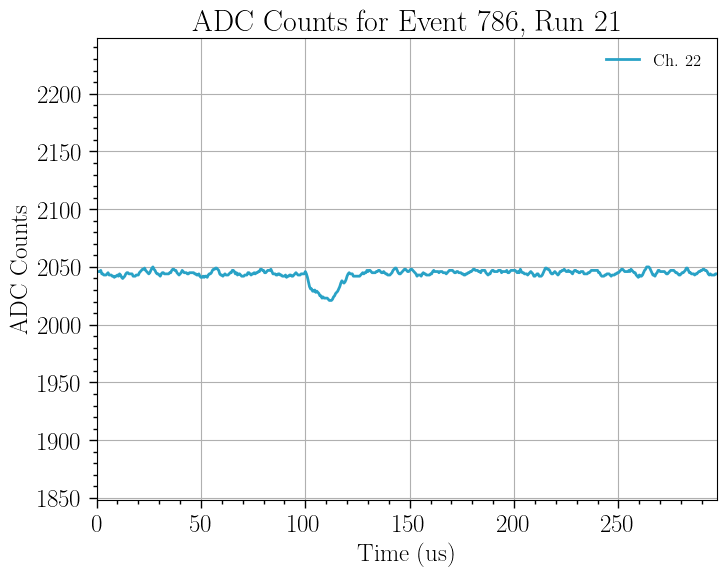

On Event 787
On Event 788


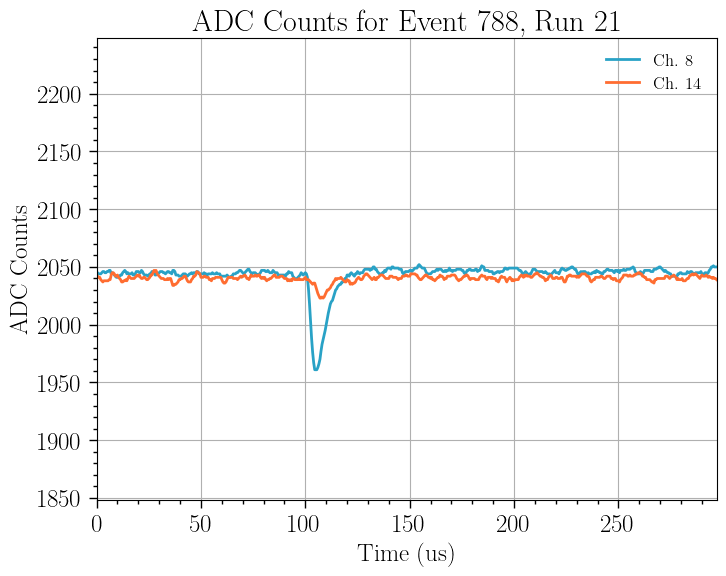

On Event 789
On Event 790
On Event 791
On Event 792
On Event 793
On Event 794
On Event 795
On Event 796
On Event 797
On Event 798
On Event 799
On Event 800
On Event 801
On Event 802
On Event 803
On Event 804
On Event 805
On Event 806
On Event 807
On Event 808
On Event 809
On Event 810
On Event 811
On Event 812
On Event 813
On Event 814
On Event 815
On Event 816


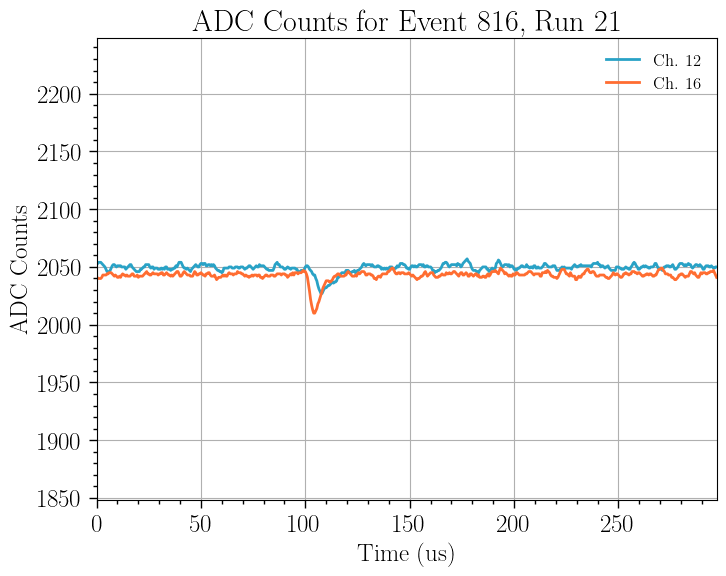

On Event 817
On Event 818
On Event 819
On Event 820
On Event 821
On Event 822


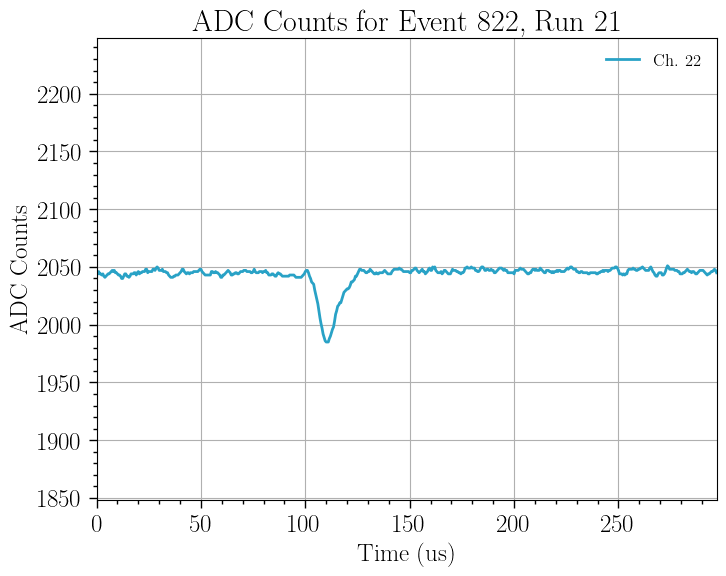

On Event 823
On Event 824
On Event 825
On Event 826
On Event 827
On Event 828
On Event 829
On Event 830
On Event 831
On Event 832
On Event 833
On Event 834
On Event 835
On Event 836
On Event 837
On Event 838
On Event 839
On Event 840
On Event 841
On Event 842
On Event 843
On Event 844
On Event 845
On Event 846
On Event 847
On Event 848
On Event 849
On Event 850
On Event 851
On Event 852
On Event 853
On Event 854
On Event 855
On Event 856
On Event 857
On Event 858
On Event 859
On Event 860
On Event 861
On Event 862
On Event 863
On Event 864
On Event 865
On Event 866
On Event 867
On Event 868
On Event 869
On Event 870
On Event 871
On Event 872
On Event 873
On Event 874
On Event 875
On Event 876
On Event 877
On Event 878
On Event 879
On Event 880
On Event 881
On Event 882
On Event 883
On Event 884
On Event 885
On Event 886
On Event 887
On Event 888
On Event 889
On Event 890
On Event 891
On Event 892
On Event 893
On Event 894


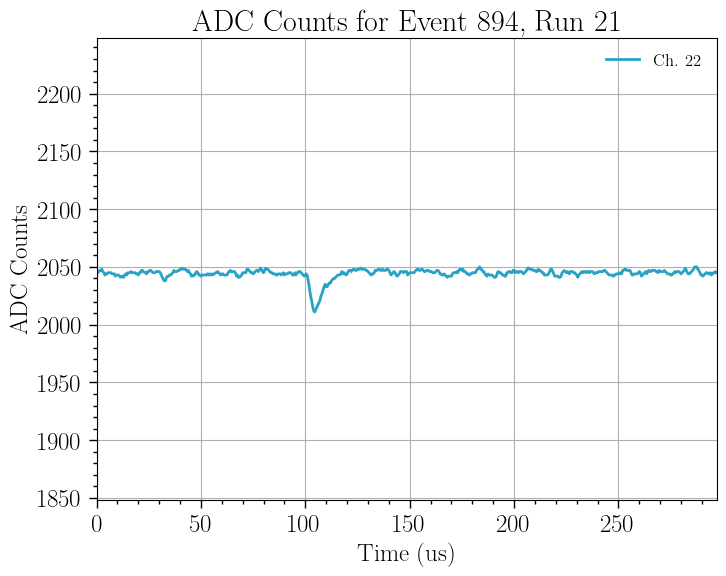

On Event 895
On Event 896
On Event 897
On Event 898
On Event 899
On Event 900
On Event 901
On Event 902
On Event 903
On Event 904
On Event 905
On Event 906
On Event 907


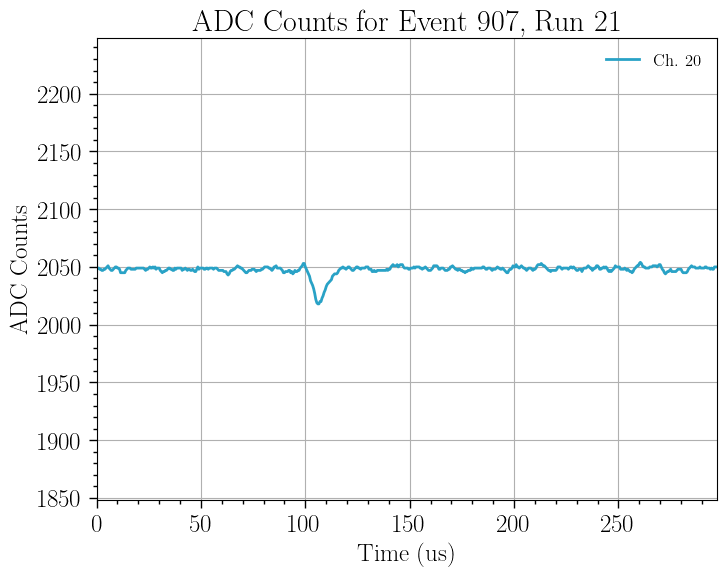

On Event 908
On Event 909
On Event 910
On Event 911
On Event 912
On Event 913
On Event 914
On Event 915
On Event 916
On Event 917
On Event 918
On Event 919
On Event 920
On Event 921
On Event 922


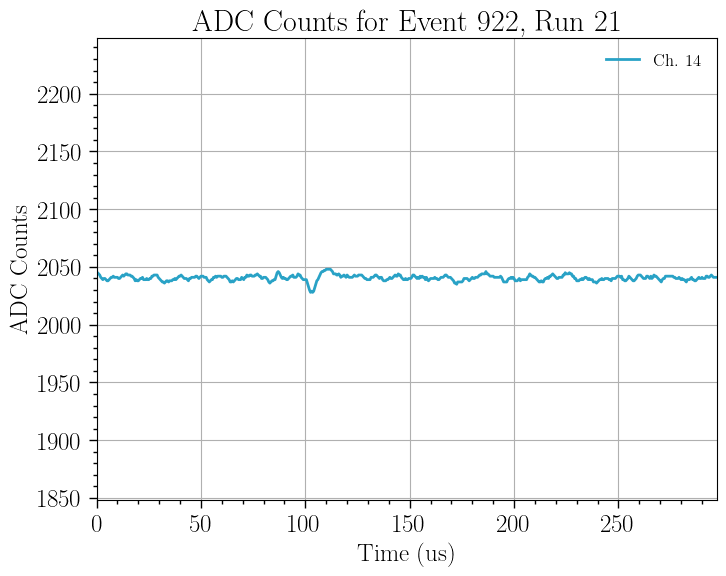

On Event 923


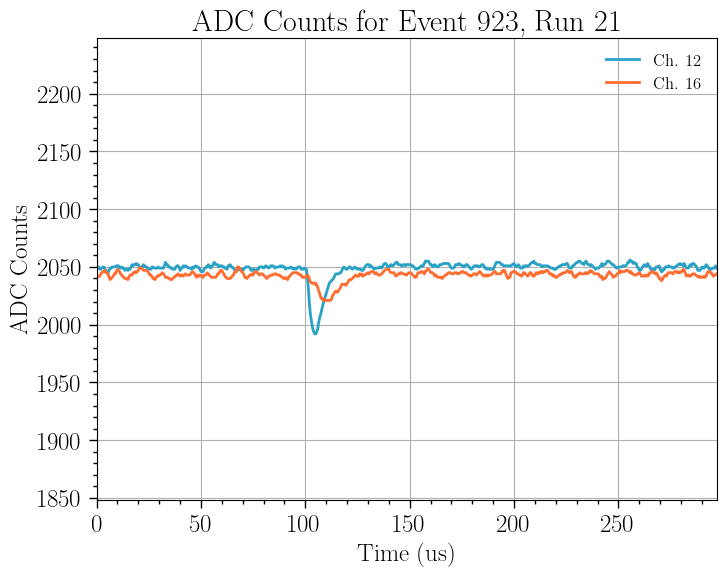

On Event 924
On Event 925
On Event 926
On Event 927
On Event 928
On Event 929
On Event 930
On Event 931
On Event 932
On Event 933
On Event 934
On Event 935
On Event 936
On Event 937
On Event 938
On Event 939
On Event 940
On Event 941
On Event 942
On Event 943
On Event 944
On Event 945
On Event 946
On Event 947
On Event 948
On Event 949
On Event 950
On Event 951


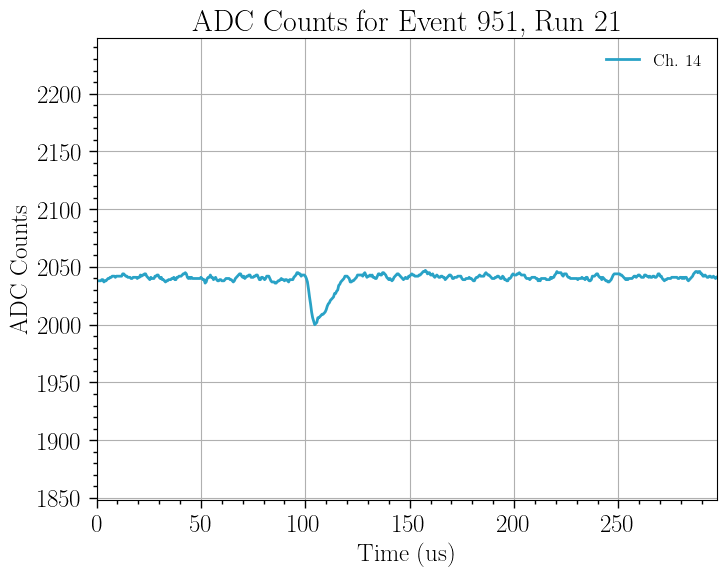

On Event 952
On Event 953
On Event 954
On Event 955
On Event 956
On Event 957
On Event 958
On Event 959
On Event 960
On Event 961


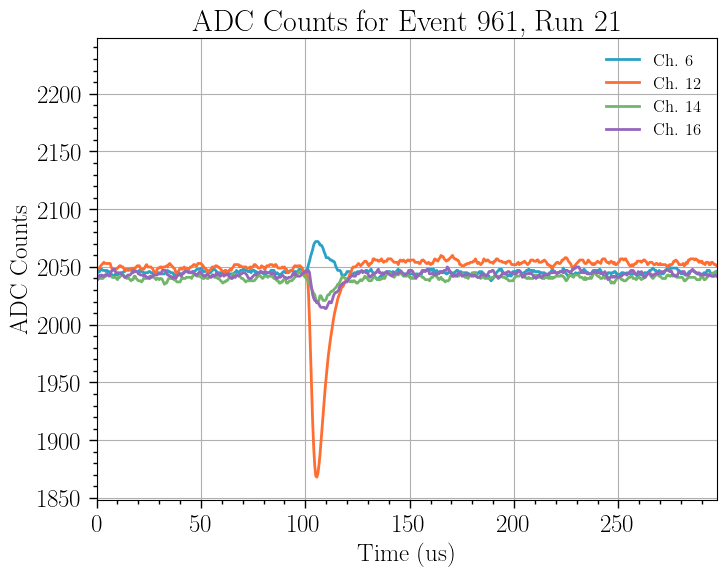

On Event 962


In [73]:
file_list = [21]
num_of_events = 963
for i in range(1, num_of_events):
    print("On Event {}".format(i))
    plot_all_channels_for_event(file_list, i, disc=20, zoom=200, hide=True)

Once we've found events of interest, we can single them out and save them if needed.

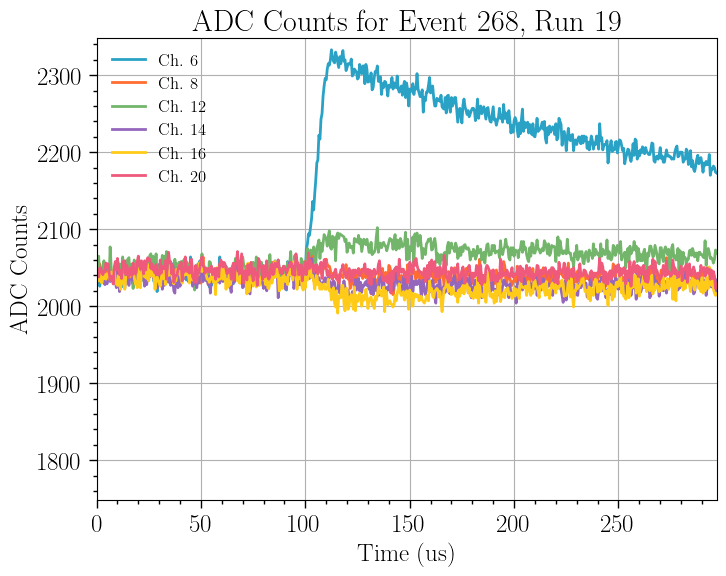

In [64]:
plot_all_channels_for_event(file_list=[19], event=268, disc=20, zoom=300, hide=True, saveas='png')

### Event-Averaged, Specific Channel

In [15]:
def plot_average_for_channel(file_list, channel, zoom=0, saveas=''):
    # set baseline (0.5*4096)
    baseline=2048

    for filename in file_list:
        inds = change_inds[filename]
        df = df_dict[filename]
        nsamps = inds[1][1]
        sum_counts = np.zeros(nsamps)
        sum_squares = np.zeros(nsamps)

        # create time axis (2 MHz sampling rate -> 0.5 us steps)
        time = 0.5*np.arange(nsamps)
        selected_samples = select_all_events_for_channel(df, inds, channel)
        plt.figure(figsize=[8,6])
        
        for i in range(len(selected_samples)):
            adc_counts = selected_samples[i]['adc_count']
            if(len(adc_counts)!=nsamps):
                print('Ch: {} Event: {} Found missing adc counts. {} instead of {}'.format(i+1, event, len(adc_counts), nsamps))
            else:
                sum_counts  += adc_counts.values
                sum_squares += adc_counts.values ** 2
    
        average_counts = sum_counts / len(selected_samples)
        variance = (sum_squares / len(selected_samples)) - (average_counts ** 2)
        std_deviation = np.sqrt(variance)

        plt.plot(time, average_counts, label='Average')
        plt.fill_between(time, average_counts - std_deviation, average_counts + std_deviation, color = colors[0], alpha=0.3, label='Std Dev')
        plt.title(f'ADC Counts for Channel {channel}, Run {filename}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        if zoom!=0: plt.ylim(baseline-zoom, baseline+zoom)
        else: plt.ylim(0, 4096)
        plt.legend(loc='best')
        plt.grid(True)
        if saveas: plt.savefig(f'{savedir}/AveragedADCCountsRun{filename}.{saveas}', dpi=400, bbox_inches='tight')
        plt.show()
        
    return

**`plot_average_for_channel()` takes the following inputs:**
- `file_list`: list of runs
- `channel`: channel number
- `zoom`: y-axis zoom. `zoom=100` means the y-axis will range from +/-100 ADC counts about the baseline. set to zero for no zoom
- `saveas`: file extension to save plot ('pdf', 'png', 'jpg', etc.). plots will be saved to `savedir`. set `save=''` for no saving

This function is only really useful if you are reading out an injected pulse with a consistent trigger.

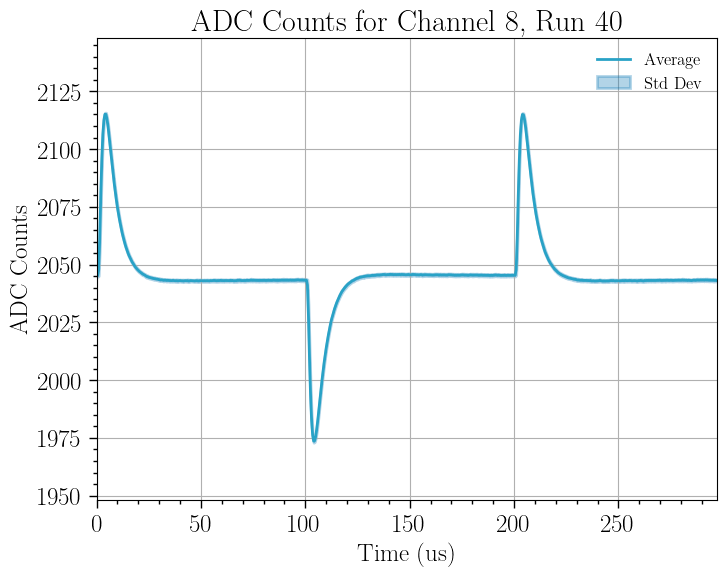

In [16]:
plot_average_for_channel(file_list=[40], channel=8, zoom=100, saveas='png')

## ADC Calibration

The ADC calibration analysis expects a set of single-channel runs with injected pulses of varying amplitudes. The input amplitudes should be documented in the associated test .csv file. Given this data, the following functions are available:
- **ADC Peak Amplitude vs. Input Charge**: `plot_peaks_vs_Q()` plots peak ADC counts (event-averaged) versus input charge.
- **Linear Fit and ADC Characteristics**: `linearity()` plots peak ADC counts (event-averaged) versus input charge with the linear fit superimposed and returns a table with resolution, dynamic range, and saturation point in terms of charge units and voltage units.

The cell below defines `findpeaks()`, a helper function used by both `plot_peaks_vs_Q()` and `linearity()`.

In [98]:
# finds event-averaged peak ADC counts and corresponding input charge for each run
def findpeaks(channels):
    # initialize peaks and charge outputs
    baseline=2048
    peaks = dict()
    Q = dict()

    # loop through channels
    for ch in channels:
        # extract file_list and pulse heights for given channel
        mask_ch = csv[csv['ADC Ch.'].isin([ch])]
        files = mask_ch['File ID'].tolist()
        mV = mask_ch['Input (mVpp)'].tolist()

        # need to mask again to ensure we only use files that were loaded into df_dict
        file_mask = [file for file in files if file in filenames] 
        mV_mask = [mv for file, mv in zip(mask_ch['File ID'], mask_ch['Input (mVpp)']) if file in filenames]

        
        # convert mV to charge
        Vdiv = (1/11) # preamp voltage divider
        Cin = 1 # preamp input capacitance, in pF
        Q[ch] = (np.array(mV_mask) * Vdiv * 10**-3) * (Cin * 10**-12) * 10**15 # charge in fC
        
        # intialize peaks output for specific channel
        peaks[ch] = []
        # loop through all runs for specific channel
        for filename in file_mask:
            df = df_dict[filename]

            # find FEM for run
            fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
            
            # slice dataframe for FEM and desired channel, find max height for each event
            mask = np.logical_and(df['fem_id'] == fem_id ,df['channel_id'] == ch)
            
            # find unique event IDs
            event_ids = np.unique(df['event_id'][mask])
            max_counts = []
            for event in event_ids:
                mask = df['event_id']==event
                max_counts = np.max(np.abs(df['adc_count'][mask] - baseline))+baseline
            peaks[ch].append(max_counts.mean())
            
    return peaks, Q

### ADC Peak Amplitude vs. Input Charge

In [9]:
def plot_peaks_vs_Q(channels, overlay=1, zoom=0, saveas=''):
    peaks, Q = findpeaks(channels)
    # if overlay is enabled, plot on the same figure
    if overlay:
        figure = plt.figure(figsize=[9,6])
        [plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}') for c in channels]
        plt.title(f'ADC Amplitude vs. Input Charge')
        plt.xlabel('Input Charge (fC)', fontsize=20)
        plt.ylabel('Counts')
        if zoom!=0: plt.ylim(zoom[0], zoom[1])
        else: plt.ylim(plt.ylim()[0], 4150)
        plt.grid(True)
        plt.legend(loc='best')
        if saveas: plt.savefig(f'{savedir}/ADCAmpvsCharge.{saveas}', dpi=400, bbox_inches='tight')
        plt.show()
    else:
        for c in channels:
            plt.figure(figsize=[9,6])
            plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}')
            plt.title(f'ADC Amplitude vs. Input Charge, Ch.{c}')
            plt.xlabel('Input Charge (fC)', fontsize=20)
            plt.ylabel('Counts')
            if zoom!=0: plt.ylim(zoom[0], zoom[1])
            else: plt.ylim(plt.ylim()[0], 4150)
            plt.grid(True)
            if saveas: plt.savefig(f'{savedir}/ADCAmpvsCharge_Ch{c}.{saveas}', dpi=400, bbox_inches='tight')
            plt.show()
    return

**`plot_peaks_vs_Q()` takes the following inputs:**
- `channels`: list of channels to plot
- `overlay`: by default `overlay=1` overlays individual channel plots. `overlay=0` will create separate plots
- `zoom`: y-axis zoom. `zoom=[2048, 2500]` sets the y-axis limits from 2048 to 2500 ADC counts. set `zoom=0` for default (minimum amplitude to 4150)
- `saveas`: file extension to save plot ('pdf', 'png', 'jpg', etc.). plots will be saved to `savedir`. set `save=''` for no saving

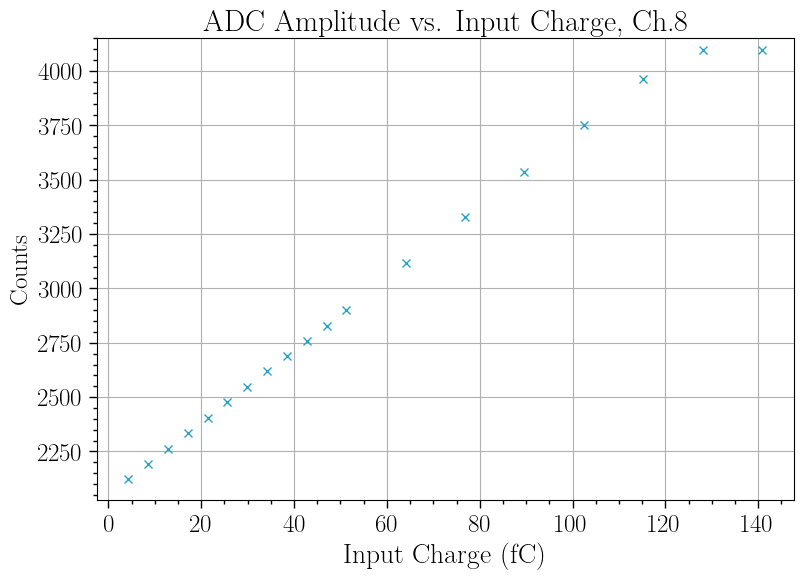

In [10]:
plot_peaks_vs_Q(channels=[8], overlay=0, zoom=0, saveas='')

### Linear Fit and ADC Characteristics

In [14]:
def line(params, x, y):
    m, b = params
    return np.sum((y - (m * x + b)) ** 2)

def linearity(channels, range=[0,10], zoom=0, saveas=''):
    for c in channels:
        peaks, Q = findpeaks([c])
        peaksrange = np.array(peaks[c][range[0]:range[1]])
        Qrange = np.array(Q[c][range[0]:range[1]])

        guess = [1.0, 2048.0]
        
        # perform the minimization
        result = minimize(line, guess, args=(Qrange, peaksrange))
        
        # results
        m, b = result.x

        # calculate calibration params
        res = m # counts/fC
        dyn_range = 4096*1/res # fC
        sat_point = (4095-b)/res # fC

        Vdiv = (1/11) # preamp voltage divider
        Cin = 1 # preamp input capacitance, in pF
        
        res_V = Vdiv*(m * 10**15)*(Cin * 10**-12)* 10**-3 # counts/mV
        dyn_range_V = 4096*1/res_V * 10**-3 # V
        sat_point_V = (4095-b)/res_V * 10**-3 # V

        # plot
        plt.figure(figsize=[9,6])
        plt.plot(Q[c], peaks[c], marker='o', fillstyle='none', linestyle='None')
        x_range = np.linspace(0, sat_point, 100)
        plt.plot(x_range, (m*x_range + b), color=colors[0], alpha =0.3)
        plt.axhline(y=4095, color='r', alpha=0.5, linestyle='--', label='Saturation')
        plt.title(f'ADC Amplitude vs. Input Charge, Ch.{c}')
        plt.gca().set_xlim(left=0)
        if zoom!=0: plt.ylim(zoom[0], zoom[1])
        else: plt.ylim(plt.ylim()[0], 4150)
        plt.xlabel('Input Charge (fC)', fontsize=20)
        plt.ylabel('Counts')
        plt.legend()
        plt.grid(True)
        if saveas: plt.savefig(f'{savedir}/ADCAmpvsChargeLinearFitCh{c}.{saveas}', dpi=400, bbox_inches='tight')
        plt.show()

        # tabulate and display params
        params = {
            "Parameter": ["Resolution", "Dynamic Range", "Saturation Point"],
            "Charge": [f'{round(res,2)} counts/fC', f'{round(dyn_range,2)} fC', f'{round(sat_point,2)} fC'],
            "Volts": [f'{round(res_V,2)} counts/mV', f'{round(dyn_range_V,2)} V', f'{round(sat_point_V,2)} V']
        }
        params_df = pd.DataFrame(params)
        display(params_df)
    return

**`linearity()` takes the following inputs:**
- `channels`: list of channels to plot
- `range`: anticipated linearity region to apply the fit; `range=[0,5]` sets the linear region from the 0th to the 5th index of `peaks`
- `zoom`: y-axis zoom. `zoom=[2048, 2500]` sets the y-axis limits from 2048 to 2500 ADC counts. set `zoom=0` for default (minimum amplitude to 4150)
- `saveas`: file extension to save plot ('pdf', 'png', 'jpg', etc.). plots will be saved to `savedir`. set `save=''` for no saving

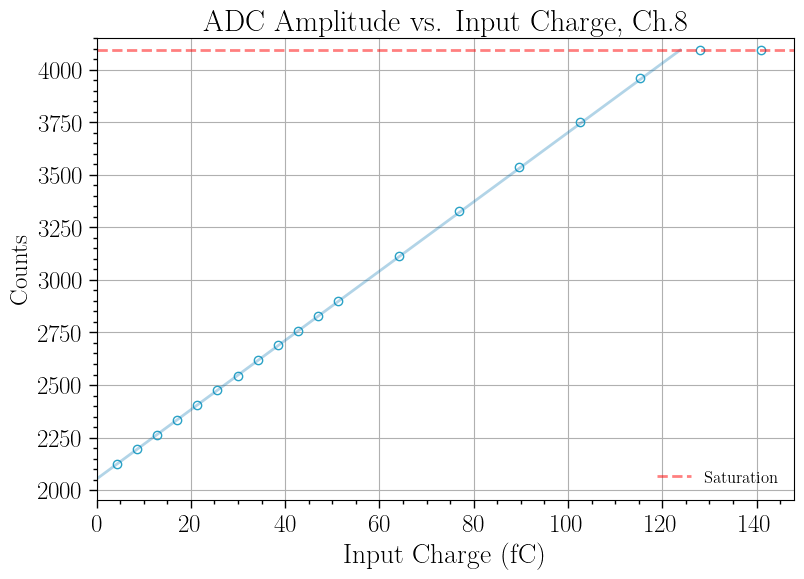

,Parameter,Charge,Volts
0,Resolution,16.5 counts/fC,1.5 counts/mV
1,Dynamic Range,248.24 fC,2.73 V
2,Saturation Point,123.8 fC,1.36 V


In [13]:
linearity(channels=[8], range=[0,5], saveas='png')

## Noise Analysis

The noise analysis expects baseline runs (no pulses). The following function is available:
- **Baseline Histograms**: `noise_hist()` histograms ADC counts and fits a Gaussian to the result. Returns noise RMS and mean for each channel.
- **Plot Noise RMS**: `noise_rms()` bar plot showing noise RMS for each channel

In [106]:
def noise_counts(file_list, channels):
    counts = {}
    for filename in file_list:
        df = df_dict[filename]
        inds = change_inds[filename]
        nsamps = inds[1][1]

        for ch in channels:
            selected_samples = select_all_events_for_channel(df, inds, ch)
            counts[ch] = []
            for i in range(len(selected_samples)-1):
                adc_counts = selected_samples[i+1]['adc_count']
                if(len(adc_counts)!=nsamps):
                    print('Ch: {} Event: {} Found missing adc counts. {} instead of {}'.format(ch, i+1, len(adc_counts), nsamps))
                else:
                    counts[ch].append(selected_samples[i+1]['adc_count'].values)
            counts[ch] = np.concatenate(counts[ch])
    return counts

def gaussian(x, mean, std):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std**2))

In [107]:
def noise_hist(file_list, counts, channels, range=50, num_bins=80, subplot=3, saveas=''):
    # based on input range and desired num_bins, create bins
    bins = np.linspace(2048 - (range/2), 2048 + (range/2), num_bins)
    means = [] 
    stds = []

    # if there is only one input channel, automatically turn off subplot
    if len(channels)==1: subplot=0

    # if subplot is enabled, find number of rows necessary and initialize plot
    if subplot:
        rows = len(channels) // subplot + (len(channels) % subplot > 0)
        if len(channels)>=subplot: 
            fig, axs = plt.subplots(rows, subplot, figsize=(14, 4*rows))
        else: 
            fig, axs = plt.subplots(rows, len(channels), figsize=(14, 4*len(channels)))
        
    for i, ch in enumerate(channels):
        if subplot:
            row = i//subplot # row index
            col = i%subplot # column index
            ax = axs[row, col]
        else:
            plt.figure(figsize=(7, 6))
            ax = plt.gca()
        
        # create histogram for current channel, find bin midpoints
        hist, bin_edges = np.histogram(counts[ch], bins=bins, density=True)
        midpoints = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        # fit gaussian to midpoints, initial guess based on mean and std of counts
        params, _ = curve_fit(gaussian, midpoints, hist, [np.mean(counts[ch]), np.std(counts[ch])])
        mean, std = params
        means.append(mean)
        stds.append(std)

        # plot histogram
        ax.hist(counts[ch], bins=bins, histtype='step', color=colors[0], density=True)

        
        # plot fitted gaussian
        x = np.linspace(min(bins), max(bins), 100)
        fit = gaussian(x, mean, std)
        ax.fill_between(x, 0, fit, color=colors[9], alpha=0.5, label='Gaussian Fit')

        # plot expected and actual baseline positions
        ax.axvline(2048, color='r', ls='--', alpha=0.5, label='Expected BL')   
        ax.axvline(mean, color='r', ls='--', label='Actual BL')

        # title and legend
        ax.set_title(f'Baseline Counts for Ch. {ch}')
        ax.legend()
        
    plt.tight_layout()
    if saveas: plt.savefig(f'{savedir}/BaselineCountsRun{file_list}.{saveas}', dpi=400, bbox_inches='tight') # save plot

    # tabulate and display results
    results = {
        "Ch": channels,
        "Mean Counts": means,
        "RMS Counts": stds
    }
    results_df = pd.DataFrame(results)
    display(results_df)
        
    return means, stds

,Ch,Mean Counts,RMS Counts
0,8,2044.323619,0.650788


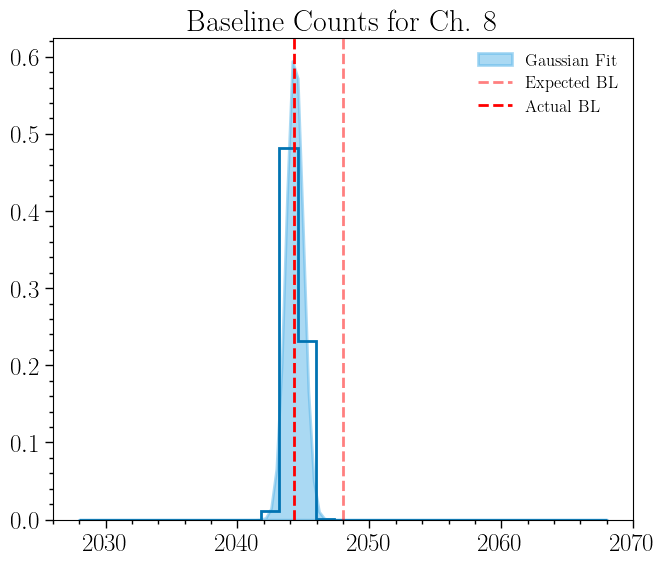

In [46]:
channels = [8]
file_list = [26]
counts = noise_counts(file_list, channels)
means,stds=noise_hist(file_list, counts, channels, 40, 30, 3, 'png')

[6, 8] [0.4943208611767638, 0.4449668563074986]


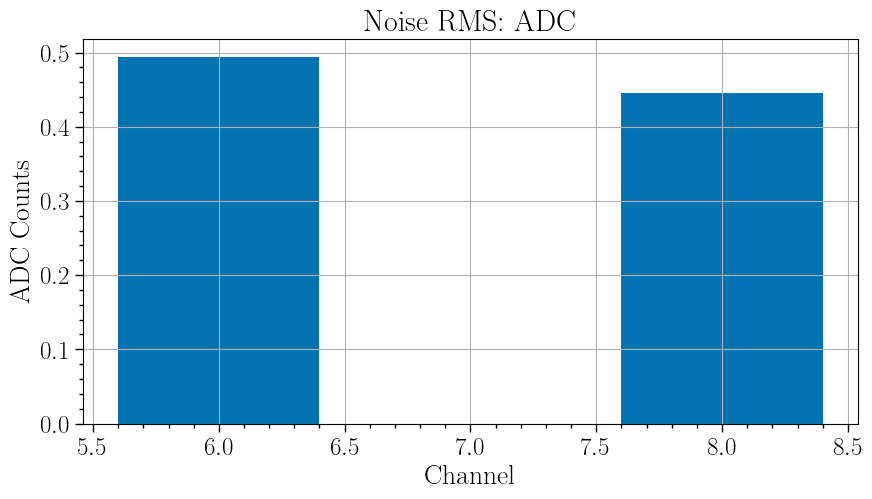

In [106]:
channels = [key for key in counts.keys()]
noise_rms = []
for ch in channels:
    mean = np.mean(counts[ch])
    squared_diffs = (counts[ch] - mean) ** 2
    mean_squared_diff = np.mean(squared_diffs)
    noise_rms.append(np.sqrt(mean_squared_diff))

print(channels, noise_rms)
    
plt.figure(figsize=[10,5])
# plt.step(channels, noise_rms, color=colors[0], where='mid')
plt.bar(channels, noise_rms, color=colors[0])
plt.xlabel('Channel', fontsize=20)
plt.ylabel('ADC Counts', fontsize=20)
plt.title('Noise RMS: ADC')
# plt.savefig(f'{savedir}/NoiseRMSADC.png', dpi=400, bbox_inches='tight')
plt.grid()
plt.show()

## Pulse Fitting

In [30]:
def trim_pulse(file_list, channel, saveas=''):
    # set baseline (0.5*4096)use noise baseline
    baseline=2048

    for filename in file_list:
        inds = change_inds[filename]
        df = df_dict[filename]
        nsamps = inds[1][1]
        sum_counts = np.zeros(nsamps)

        # create time axis (2 MHz sampling rate -> 0.5 us steps)
        time = 0.5*np.arange(nsamps)
        selected_samples = select_all_events_for_channel(df, inds, channel)
        plt.figure(figsize=[8,6])
        
        for i in range(len(selected_samples)):
            adc_counts = selected_samples[i]['adc_count']
            if(len(adc_counts)!=nsamps):
                print('Ch: {} Event: {} Found missing adc counts. {} instead of {}'.format(channel, i+1, len(adc_counts), nsamps))
            else:
                sum_counts  += adc_counts.values
    
        avg_counts = sum_counts / len(selected_samples)
        

        # take first peak
        
        # take absolute value and subtract baseline from averaged counts; then find maximum and corresponding index
        absolute_counts = np.abs(avg_counts - baseline)
        max_counts = np.max(absolute_counts)
        max_ind = np.argmax(absolute_counts)
        
        threshold = 0.1 * max_counts
        
        # scan right before the pulse maximum to find the start point for the given threshold
        start_ind = -1 # init start (use -1 in case index ends up being zero)
        padding = 3 # number of extra indices to pad trimmed window with (adds to start and stop indices)
        cursor = 0
        while start_ind==-1:
            if absolute_counts[max_ind - cursor] <= threshold and start_ind==-1:
                start_ind = max_ind - cursor - padding
            cursor += 1

        # for now, ignoring exp decay and pretending the pulse is a symmetrical gaussian; so we set the stop point to be symmetrically placed after the max counts
        stop_ind = (max_ind-start_ind)+max_ind+45
        
        # return time and counts arrays sliced at start and stop points
        time = time[start_ind:stop_ind] - (0.5*max_ind)
        counts = absolute_counts[start_ind:stop_ind]

        # plot sliced arrays
        plt.plot(time, counts)
        plt.title(f'Trimmed Average Pulse for Channel {channel}, Run {filename}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time[0], time[-1])
        plt.ylim(0, max_counts+(0.05*max_counts))
        plt.grid(True)
        if saveas: plt.savefig(f'{savedir}/TrimmedPulse_Run{filename}.{saveas}', dpi=400, bbox_inches='tight')
        plt.show()
        
    return time, counts, max_ind

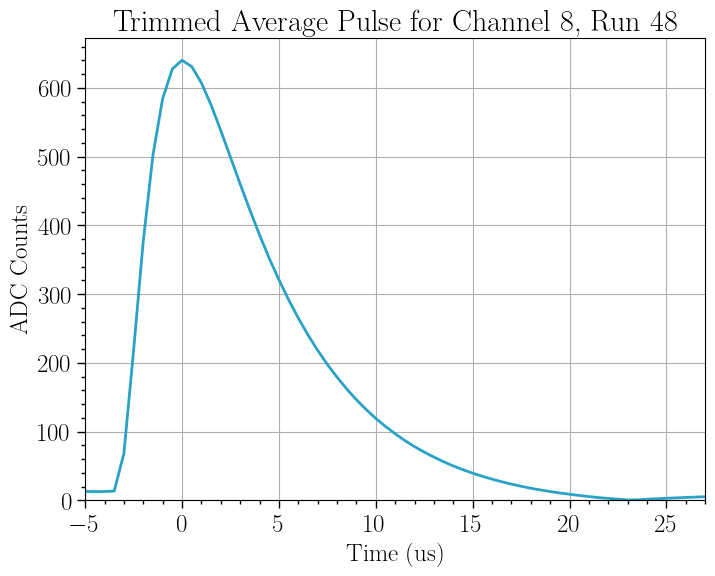

In [31]:
time, counts, max_ind = trim_pulse(file_list=[48], channel=8, saveas='')

In [32]:
from scipy import special

def gaussian(x, a, std):
        return a * np.exp(-(x)**2 / (2 * std**2))
        # return np.exp(-(x)**2 / (2 * std**2))

def exgaussian(x, a, u, std, l):
        return  a * np.sqrt(np.pi/2) * (0.5*l) * np.exp((0.5*l)*(2*u + l * std**2 - 2*x))*special.erfc((u+ l * std**2 - x)/(np.sqrt(2)*std))

def pulse_fit(time, counts, max_ind):
        # fit gaussian to trimmed pulse, initial guess based on max index location and std of counts
        params, _ = curve_fit(exgaussian, time[0:len(time)], counts[0:len(time)])
        # a, std = params
        a, u, std, l = params
        print(a, u, std, l)

        # plot pulse
        plt.plot(time, counts, label="Pulse")

        # plot fitted gaussian
        # fit = gaussian(time, a, std)
        fit = exgaussian(time, a, u, std, l)
        plt.plot(time, fit, label="Fit")

        # title and legend
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.ylim
        plt.legend(loc="best")
        plt.grid(True)
        # if saveas: plt.savefig(f'{savedir}/TrimmedPulse_Run{filename}.{saveas}', dpi=400, bbox_inches='tight')
        plt.show()
        return

/var/folders/jy/0g0x3tb57mj668c4117lhk400000gn/T/ipykernel_11061/3009153034.py:8: RuntimeWarning: overflow encountered in exp
  return  a * np.sqrt(np.pi/2) * (0.5*l) * np.exp((0.5*l)*(2*u + l * std**2 - 2*x))*special.erfc((u+ l * std**2 - x)/(np.sqrt(2)*std))


4419.676021903368 -1.6690747076296633 1.177145990682668 0.18176077091619022


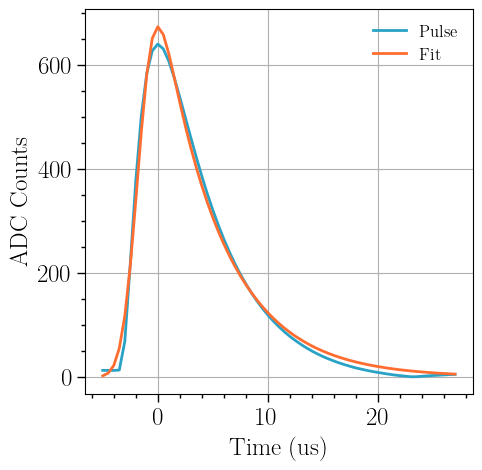

In [26]:
pulse_fit(time, counts, max_ind)

In [ ]:
# test fit out


## Crosstalk

In [55]:
#Get counts for all channels

def counts_per_channel(file_list):
#inputs: list of files you would like plotted, channel number of interest, event number of interest, and overlay on or off 
    t=0
    counts = dict()
    nloops = 0
    #Loop over files
    for filename in file_list:
        df = df_dict[filename]
        # find FEM ID for run
        fem_id = 14 #csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
        # filter data by FEM and desired channel
        fem_mask = df['fem_id']==fem_id

        #get all event ids in file
        all_evs = np.unique(df['event_id'])
        
        #remove any active channel if passed
        all_chs = np.unique(df['channel_id'])
        t1 = time.time()
        #loop over channels
        for ch in all_chs:
            counts[ch] = []
            nloops+=1
            #loop over events
            #t2 = time.time()
            ch_mask = (df['channel_id']==ch) & (fem_mask)
            for ev in all_evs[:10]:
                t2 = time.time()
                mask = (ch_mask) & (df['event_id']==ev)
                t4 = time.time()
                t+=(t4-t2)
                adc_counts = df['adc_count'][mask]
                if nloops<2:
                    nsamps = len(adc_counts)
                if(len(adc_counts)!=nsamps):
                    print('Skipping Ch: {} Event: {}. Found {} missing samples'.format(ch, ev, abs(len(adc_counts)-nsamps)))
                else:
                    counts[ch].append(adc_counts)
                    #sum_squares.append(adc_counts ** 2)
        t3 = time.time()
        channels = [key for key in counts.keys()]
        counts = {ch: np.concatenate(counts[ch]) for ch in channels}
        print(t3-t1)
    return channels, counts

In [56]:
channels, counts = counts_per_channel(file_list)

0.34626173973083496


In [153]:
channels = sorted(counts.keys())
adc_counts = np.array([counts[ch] for ch in channels])
adc_counts = adc_counts.T
# Normalize ADC counts to zero mean and unit variance
normalized_adc_counts = (adc_counts - np.mean(adc_counts, axis=0)) / np.std(adc_counts, axis=0)
# Compute correlation matrix
correlation_matrix = np.corrcoef(normalized_adc_counts, rowvar=False)

#Compute covariance matrix
#covariance_matrix = np.cov(normalized_adc_counts, rowvar=False)

#plt.figure(figsize=(10, 8))
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
#plt.title('Cross-Talk Correlation Matrix')
#plt.xlabel('Channels')
#plt.ylabel('Channels')
#plt.show()


### Correlation of active channel with other channels

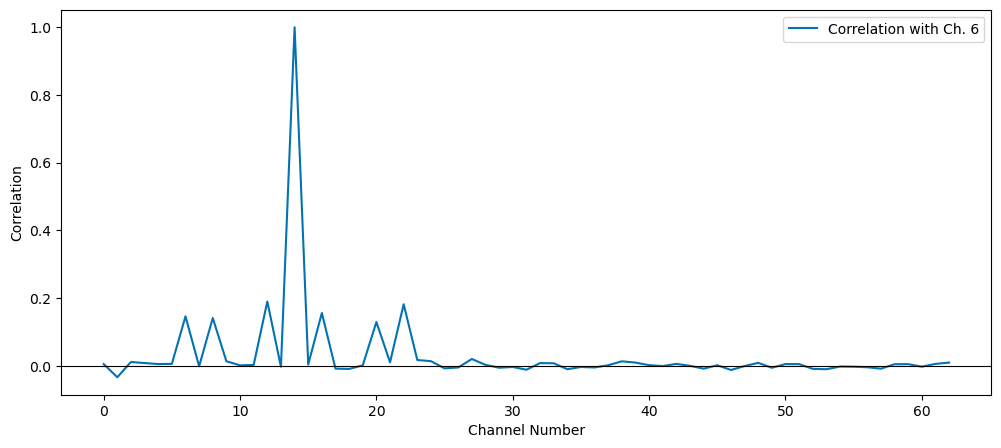

In [155]:
plt.figure(figsize=[12,5])
plt.plot(channels, correlation_matrix[14], color=colors[0], label='Correlation with Ch. {}'.format(active_ch))
plt.xlabel('Channel Number')
plt.ylabel('Correlation'.format(active_ch))
plt.axhline(0, color='black', linewidth=0.8)

plt.legend()
plt.show()

### 2D correlation matrix 

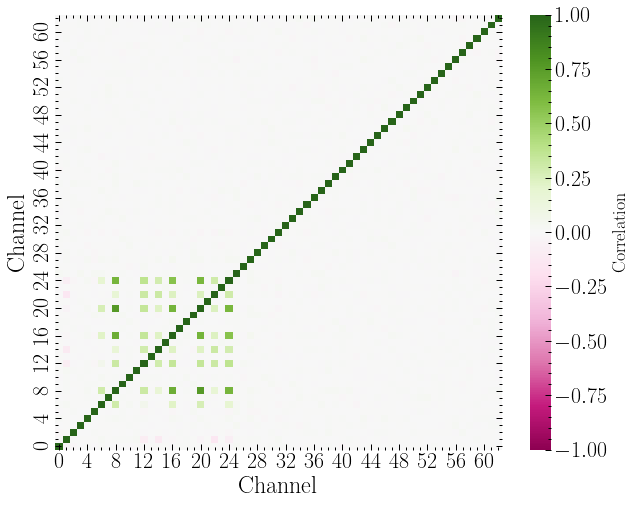

In [102]:
plt.figure(figsize=[10,8])
ax = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap='PiYG', center=0, cbar_kws={'label': 'Correlation'})
ax.invert_yaxis()
ax.set_xlabel('Channel', fontsize=24)
ax.set_ylabel('Channel', fontsize=24)
plt.show()

In [66]:
#Get noise counts for all channels (except for active one) for noise measurements

def noise_counts(file_list, active_ch):
#inputs: list of files you would like plotted, channel number of interest

    counts = dict()
    nloops = 0
    #Loop over files
    for filename in file_list:
        df = df_dict[filename]
        # find FEM ID for run
        fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
        # filter data by FEM and desired channel
        fem_mask = df['fem_id']==fem_id

        #get all event ids in file
        all_evs = np.unique(df['event_id'])
        
        #remove any active channel if passed
        all_chs = np.unique(df['channel_id'])
        non_active = np.delete(all_chs, np.where(all_chs==active_ch)[0][0])

        #loop over channels
        for ch in non_active:
            counts[ch] = []
            nloops+=1
            #loop over events
            for ev in all_evs[:1]:
                mask = np.logical_and(fem_mask, np.logical_and(df['event_id']==ev, df['channel_id']==ch))
                adc_counts = df['adc_count'][mask]
                if nloops<2:
                    nsamps = len(adc_counts)
                if(len(adc_counts)!=nsamps):
                    print('Skipping Ch: {} Event: {}. Found {} missing samples'.format(ch, ev, abs(len(adc_counts)-nsamps)))
                else:
                    counts[ch].append(adc_counts)
                    #sum_squares.append(adc_counts ** 2)
        
        channels = [key for key in counts.keys()]
        counts = {ch: np.concatenate(counts[ch]) for ch in channels}

    return counts